In [ ]:
import os
import glob
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
%matplotlib inline
import matplotlib
matplotlib.rcParams.update({'font.size':15})
import time
import cartopy.crs as ccrs
import cartopy
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/pscratch/sd/q/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)

from tools.generalTools import *; from tools.BLtools import *; from tools.e5tools import *
from tropicalOrographicRegions.mountainUtils import tilted_rect

from scipy.stats import linregress
#xr.set_options(display_style='text') 

%load_ext autoreload
%autoreload 2

In [ ]:
def sel_box_months(var,box,months,lon='longitude',lat='latitude',lat_increase=False):
    window = sel_box(var,box,lon,lat,lat_increase)
    window=sel_months(window,months)
    return window


def reorder(da):
    da.coords['longitude'] = da.coords['longitude'] % 360
    da = da.sortby(da.longitude)
    return da.reindex(latitude=list(reversed(da.latitude)))
 

In [ ]:
orogm = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
lsm = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
box = [60,150,0,30]
months = [6,7,8]
# Ghats mask
ghats_tilted_rect = [ 75  ,   9  ,  71.5, 20   ,2]

In [ ]:
imerg_monthly = xr.open_mfdataset("/global/cfs/projectdirs/m3310/qnicolas/GPM-IMERG/3B-MO*.nc").precipitation.rename({'lon':'longitude','lat':'latitude'})
imerg_monthly = reorder(imerg_monthly)
imerg_monthly['time'] = imerg_monthly.indexes['time'].to_datetimeindex()

In [ ]:
#e5_pr_monthly = 1e3*e5_monthly_timeseries('128_228_tp',range(1979,2021))
e5_pr_monthly_1979_2020 = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/e5.climatology.TP.1979-2020.zarr").TP*1e3
e5_pr_monthly_1950_1978 = 1e3*e5_monthly_timeseries('128_228_tp',range(1950,1979))
e5_pr_monthly = xr.concat((e5_pr_monthly_1950_1978,e5_pr_monthly_1979_2020),dim='time')

In [ ]:
#chirps = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/CHIRPS/chirps-v2.0.monthly.nc")
#chirps = reorder(chirps)
#%time chirps.chunk(latitude=100,longitude=100).to_zarr("/global/cfs/projectdirs/m3310/qnicolas/CHIRPS/chirps-v2.0.monthly.reindexed.zarr")
chirps_monthly = xr.open_zarr("/global/cfs/projectdirs/m3310/qnicolas/CHIRPS/chirps-v2.0.monthly.reindexed.zarr").precip/31 # convert to mm/day


In [ ]:
aphrodite_path = "/global/cfs/projectdirs/m3310/qnicolas/APHRODITE/"
aphrodite_1 = xr.open_dataset(aphrodite_path+"APHRO_MA_025deg_V1101.1951-2007.monthly.nc")
aphrodite_2 = xr.open_dataset(aphrodite_path+"APHRO_MA_025deg_V1101_EXR1.2007-2015.monthly.nc")
aphrodite_monthly = reorder(xr.concat((aphrodite_1.precip.sel(time=(aphrodite_1['time.year']<2007)),\
                                       aphrodite_2.precip.rename({'lat':'latitude','lon':'longitude'})),\
                                      dim='time'))

In [ ]:
#cru_monthly = reorder(xr.open_dataset("/pscratch/sd/q/qnicolas/CRUTSv4.06/cru_ts4.06.1901.2021.pre.dat.nc").rename({'lat':'latitude','lon':'longitude'}))
#cru_monthly.chunk(latitude=40,longitude=40).to_zarr("/pscratch/sd/q/qnicolas/CRUTSv4.06/cru_ts4.06.1901.2021.pre.dat.reindexed.zarr")
cru_monthly = xr.open_zarr("/pscratch/sd/q/qnicolas/CRUTSv4.06/cru_ts4.06.1901.2021.pre.dat.reindexed.zarr").pre/31

In [ ]:
gpcp_monthly = xr.open_dataset("/global/cfs/projectdirs/m3522/cmip6/obs4mip/observations/NASA-GSFC/Obs-GPCP/GPCP/V2.3/atmos/pr/pr_GPCP-SG_L3_v2.3_197901-201710.nc").pr
gpcp_monthly = reorder(gpcp_monthly.rename({'lat':'latitude','lon':'longitude'}))*86400
cpc_monthly = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/FROGs/1DD_V0/CPC_v1.0/CPC.monthly.1979-2019.nc").rain
gpcc_monthly = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/FROGs/1DD_V0/GPCC_FDD_2018/GPCC_FDD_v2018.monthly.1982-2016.nc").precip
persiann_monthly = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/FROGs/1DD_V0/PERSIANN_v1_r1/PERSIANN-CDRv1r1.monthly.1983-2018.nc").rain

In [ ]:
imd_monthly = xr.open_dataset("/global/cfs/projectdirs/m3310/qnicolas/IMD/IMD_rain.monthly.1901-2022.nc").RAINFALL

In [ ]:
class PrecipDataset :
    def __init__(self, data, name):
        self.name=name
        self.precip=data
        self.resolution = ("%.3f"%float(data.longitude[1]-data.longitude[0])).rstrip('0')+"°"
        self.time_range = (pd.to_datetime(data.time.min().values).strftime("%Y-%m"),pd.to_datetime(data.time.max().values).strftime("%Y-%m"))
        

In [ ]:
ERA5      = PrecipDataset(e5_pr_monthly,'ERA5 precip')
IMERG     = PrecipDataset(imerg_monthly,'IMERG')
APHRODITE = PrecipDataset(aphrodite_monthly,'APHRODITE')
CHIRPS    = PrecipDataset(chirps_monthly,'CHIRPS')
GPCP      = PrecipDataset(gpcp_monthly,'GPCP')
CPC       = PrecipDataset(cpc_monthly,'CPC')
GPCC      = PrecipDataset(gpcc_monthly,'GPCC')
PERSIANN  = PrecipDataset(persiann_monthly,'PERSIANN (=downscaled GPCP)')
IMD  = PrecipDataset(imd_monthly,'IMD')
datasets = (ERA5     ,IMERG    ,APHRODITE,CHIRPS   ,GPCP     ,CPC      ,GPCC     ,PERSIANN, IMD )

In [ ]:
%%time
for dataset in datasets:
    dataset.precip_jja_yearly = sel_box_months(dataset.precip,box = box, months=months).groupby('time.year').mean().load()
    dataset.jja_time_range = (int(dataset.precip_jja_yearly.year.min().values),int(dataset.precip_jja_yearly.year.max().values))
        

In [ ]:
%%time
for dataset in datasets:
    dataset.precip_ond_yearly = sel_box_months(dataset.precip,box = box, months=[10,11,12]).groupby('time.year').mean().load()
    dataset.ond_time_range = (int(dataset.precip_ond_yearly.year.min().values),int(dataset.precip_ond_yearly.year.max().values))
        

In [ ]:
for dataset in datasets:
    dataset.lsm = lsm.interp_like(dataset.precip_jja_yearly)>0.1
    dataset.ghats_mask = sel_box(dataset.lsm*tilted_rect(dataset.lsm,*ghats_tilted_rect),box)

In [ ]:
data_info = {
    "name": [dataset.name for dataset in datasets],
    "resolution": [dataset.resolution for dataset in datasets],
    "time_range": [dataset.time_range for dataset in datasets],
    "jja_time_range": [dataset.jja_time_range for dataset in datasets],
}
pd.DataFrame(data_info)

# Climatologies

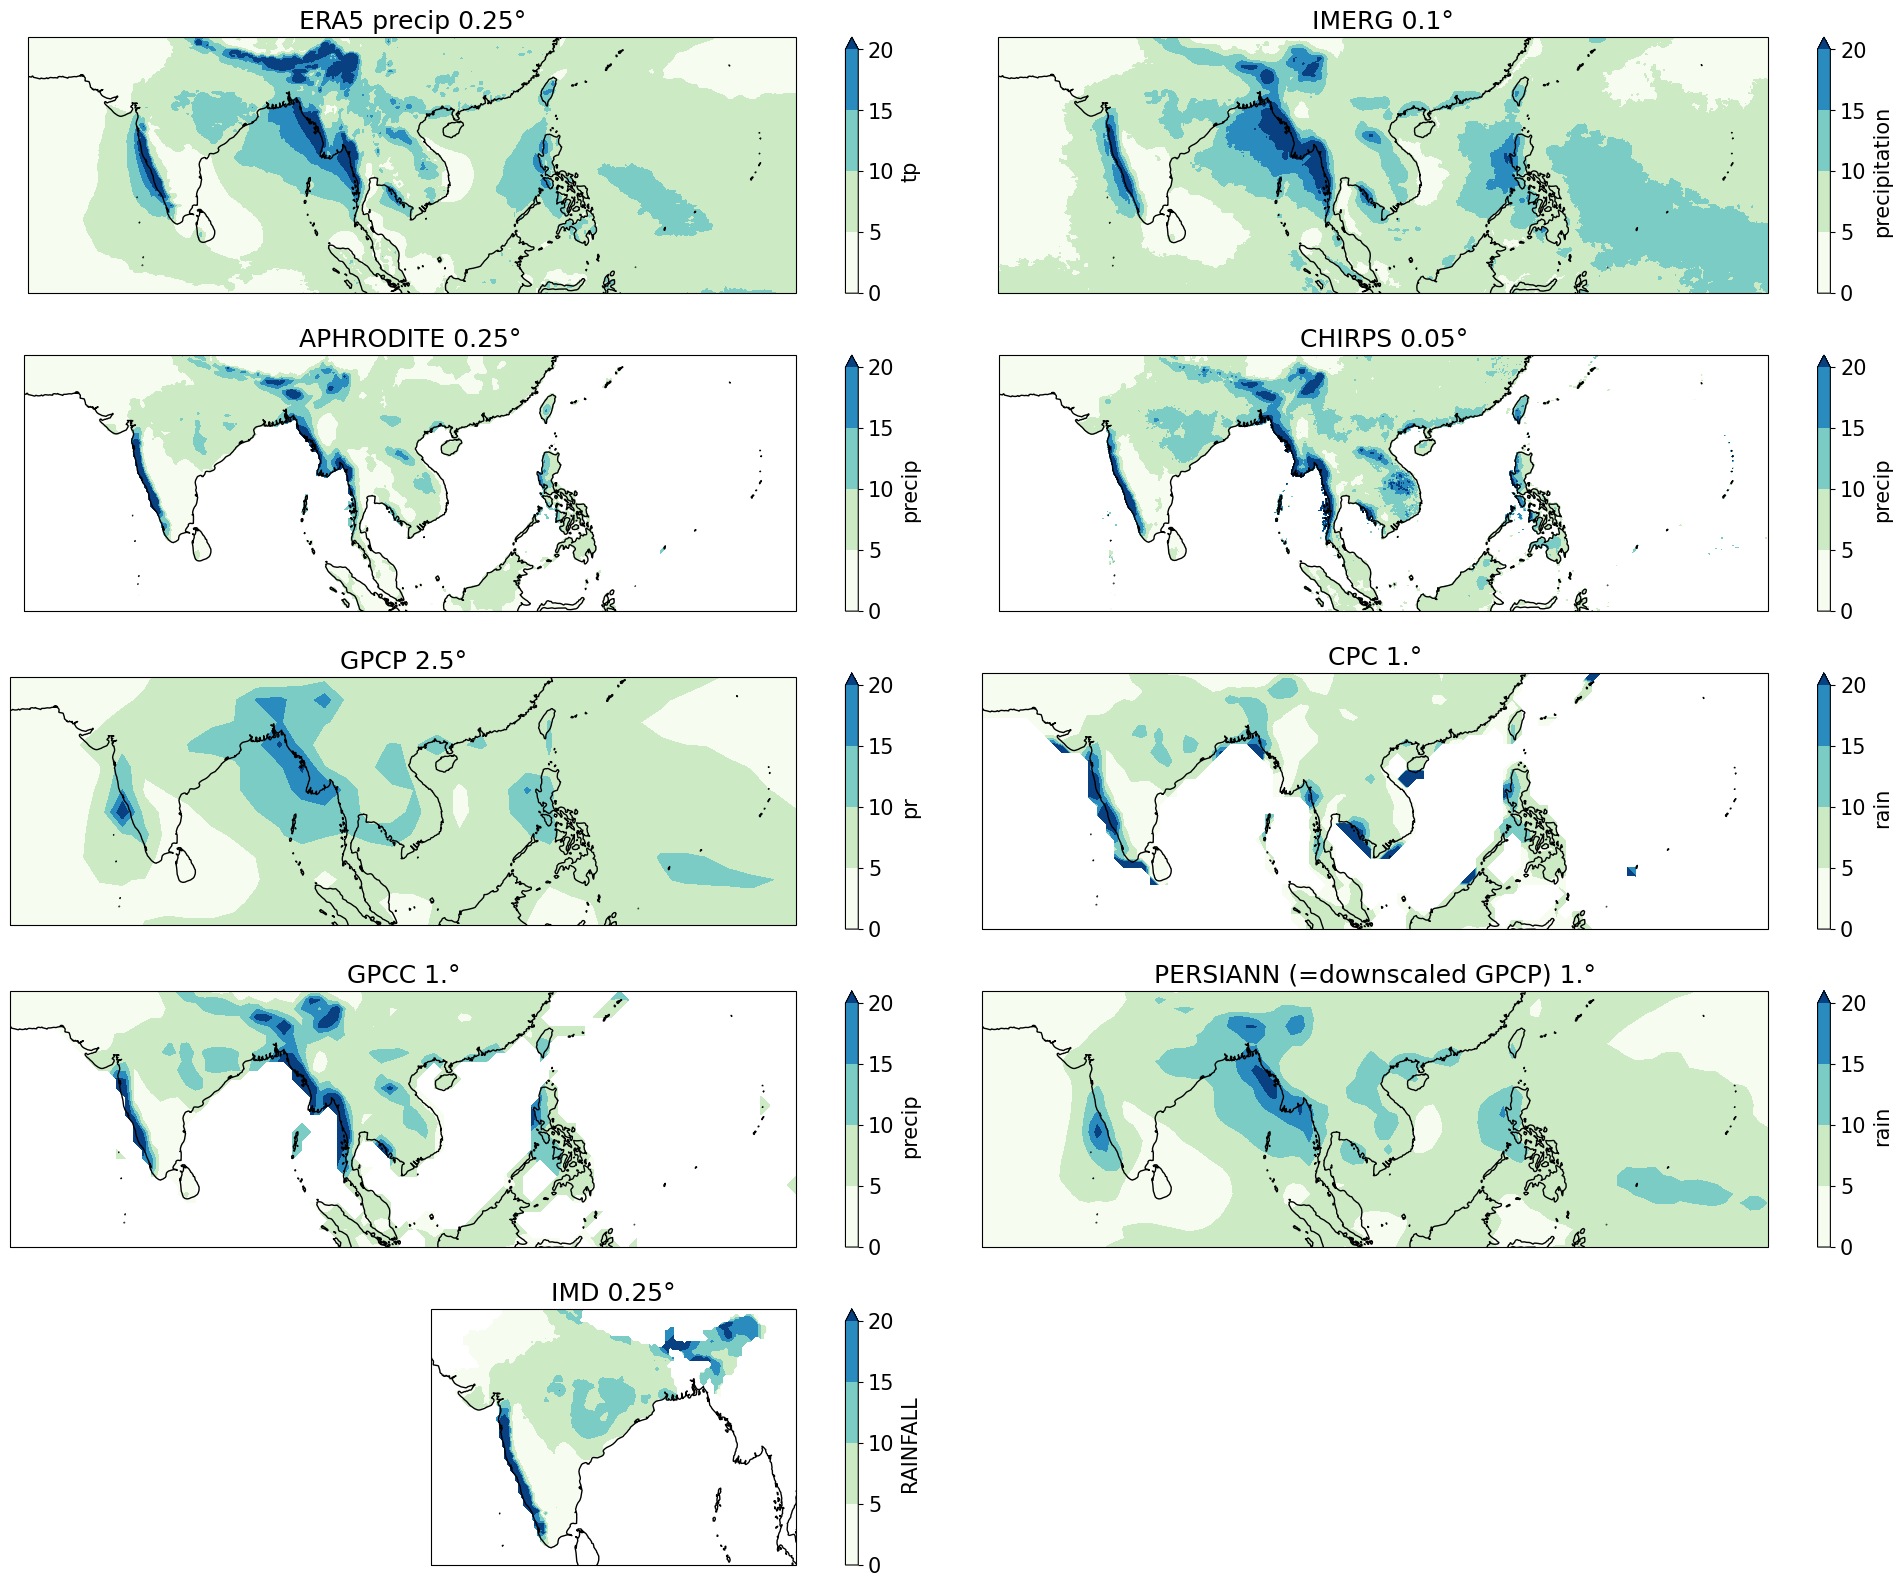

In [44]:
fig,axs=plt.subplots(5,2,figsize=(20,16),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.reshape(-1)
for dataset,ax in zip(datasets,axs):
    dataset.precip_jja_yearly.mean('year').plot.contourf(ax=ax,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu)
    ax.coastlines()
    ax.set_title(dataset.name+' '+ dataset.resolution)
fig.tight_layout()
axs[-1].remove()

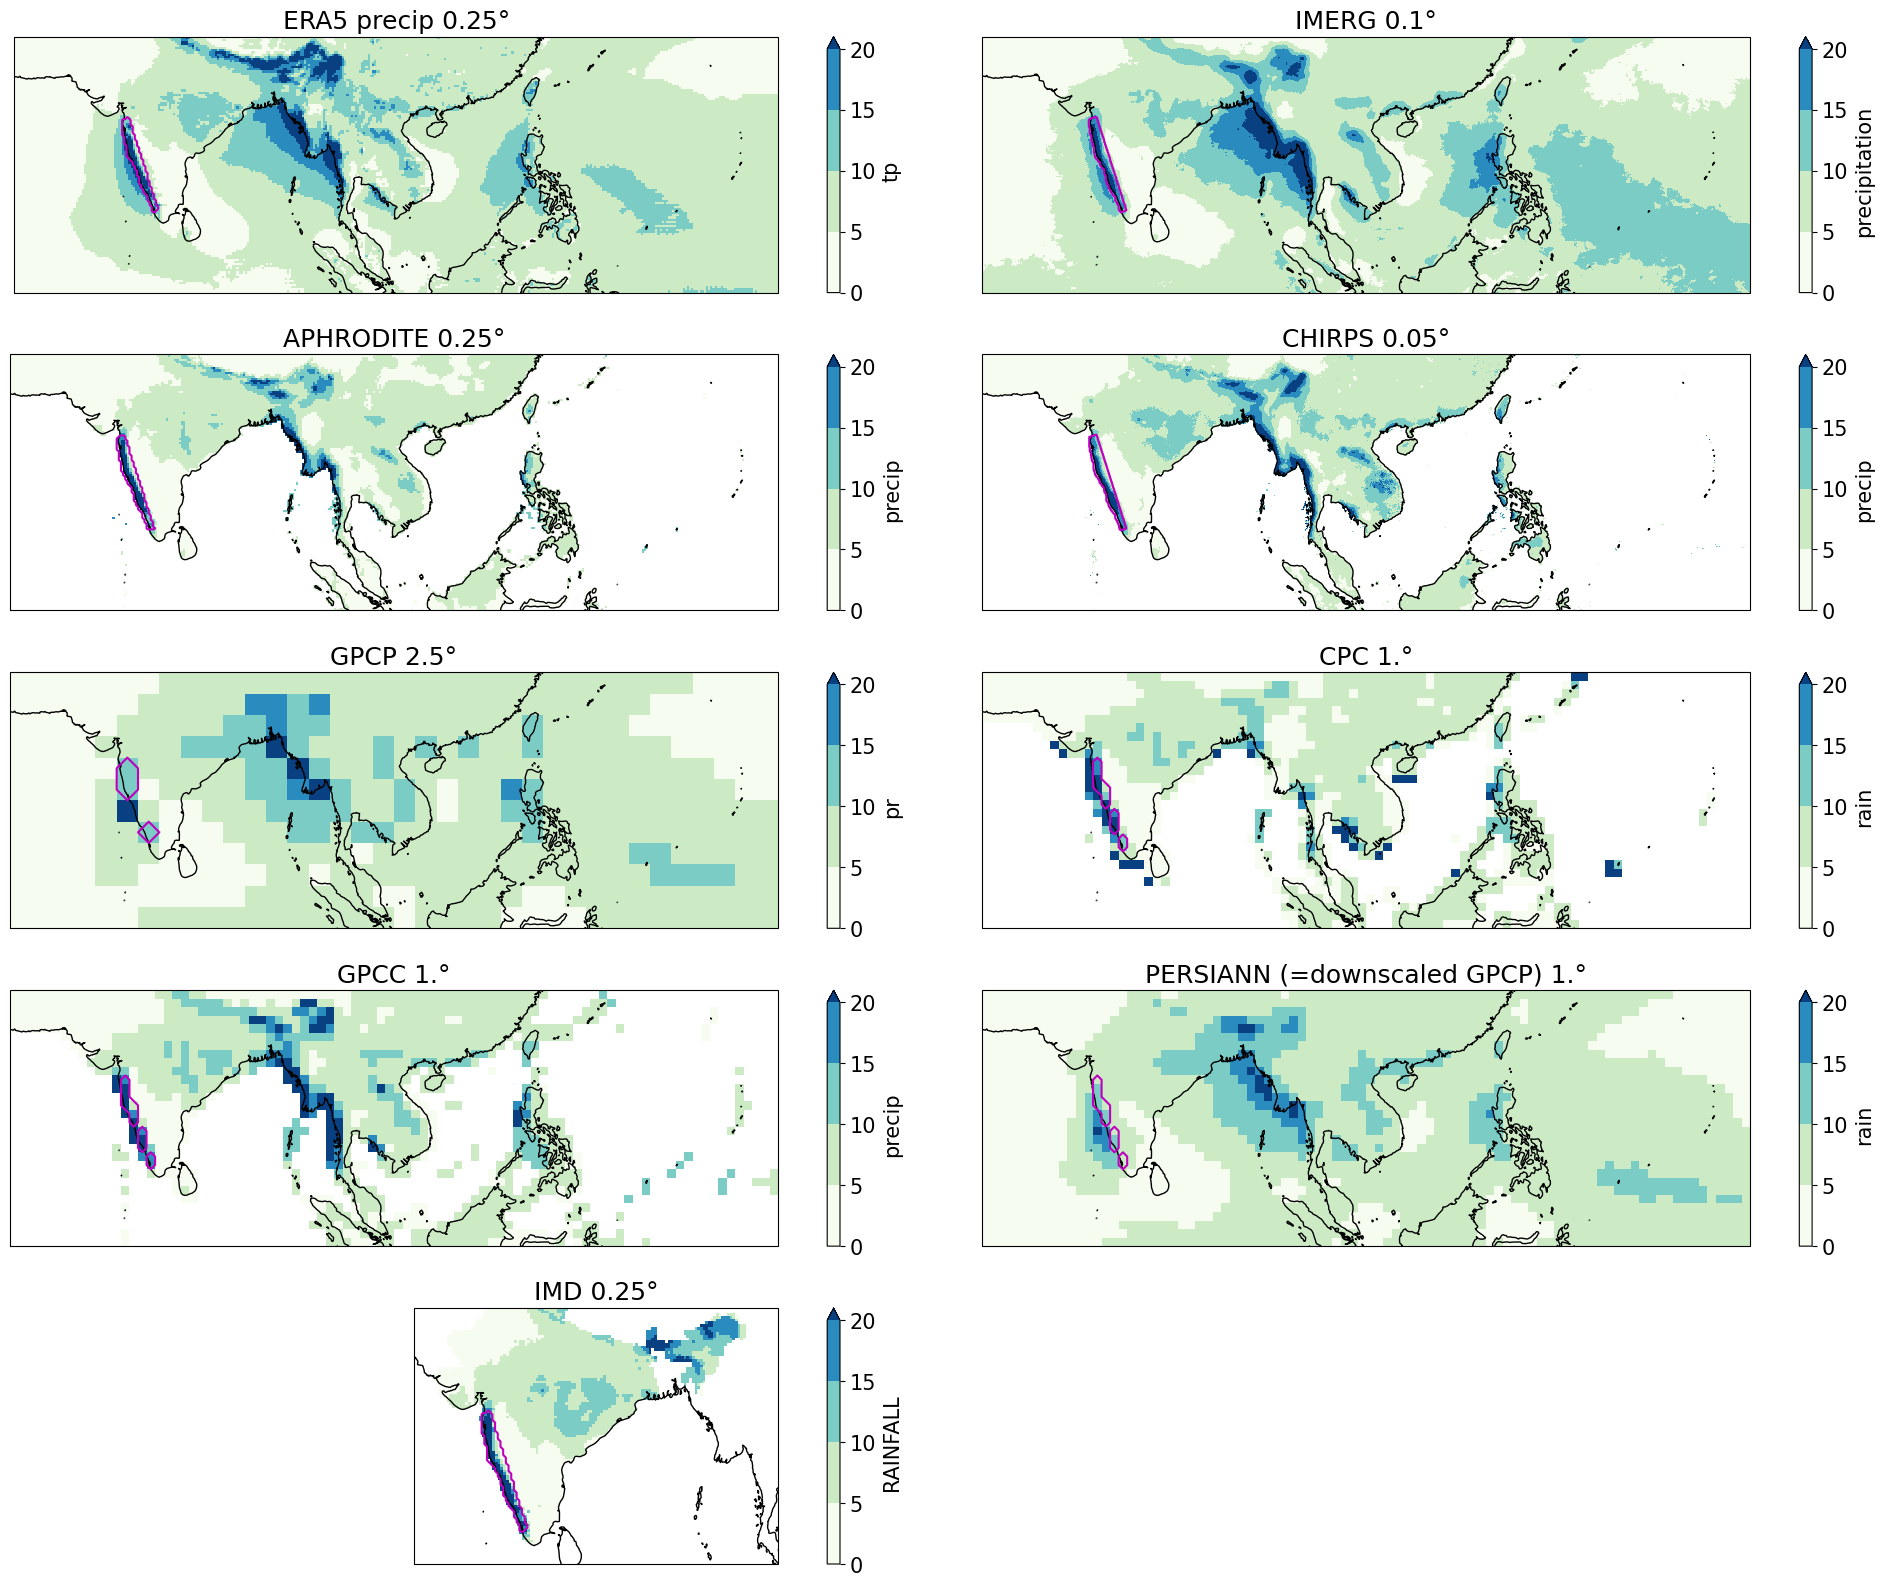

In [45]:
fig,axs=plt.subplots(5,2,figsize=(20,16),subplot_kw={'projection':ccrs.PlateCarree()})
axs = axs.reshape(-1)
for dataset,ax in zip(datasets,axs):
    dataset.precip_jja_yearly.mean('year').plot(ax=ax,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu)
    dataset.ghats_mask.plot.contour(ax=ax,levels=[0.5],colors='m',transform=ccrs.PlateCarree())
    ax.coastlines()
    ax.set_title(dataset.name+' '+ dataset.resolution)
fig.tight_layout()
axs[-1].remove()

# Trends in the Ghats

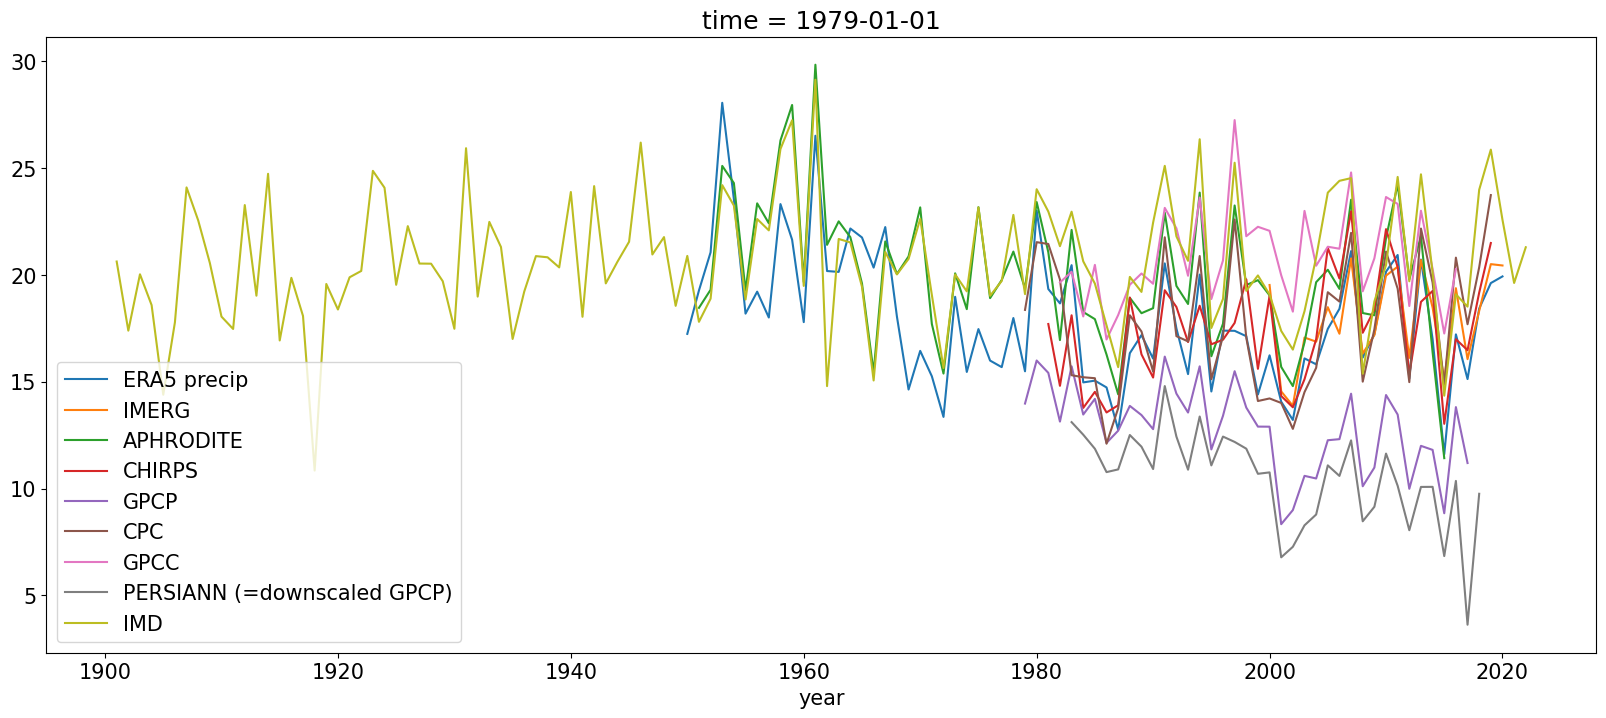

In [46]:
fig,ax=plt.subplots(1,1,figsize=(20,8))

for dataset in datasets:
    spatial_mean(dataset.precip_jja_yearly,mask = dataset.ghats_mask).plot(ax=ax,label=dataset.name)
ax.legend()

# Correlation matrix

In [47]:
corrs = np.zeros((len(datasets),len(datasets)))
for i,d1 in enumerate(datasets):
    for j,d2 in enumerate(datasets):
        ts1 = spatial_mean(d1.precip_jja_yearly,mask = d1.ghats_mask)
        ts2 = spatial_mean(d2.precip_jja_yearly,mask = d2.ghats_mask)
        ts1 = ts1.sel(year=slice(*d2.jja_time_range))
        ts2 = ts2.sel(year=slice(*d1.jja_time_range))
        corrs[i,j] = np.corrcoef(ts1,ts2)[0,1]

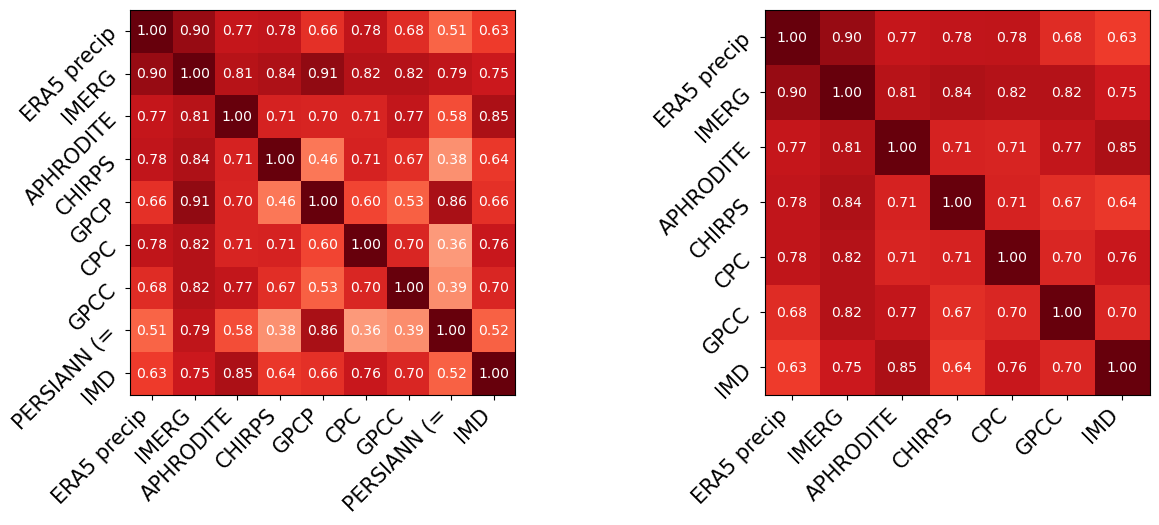

In [48]:
_,axs=plt.subplots(1,2,figsize=(15,5))
for k,idxs in enumerate((np.arange(len(datasets)),np.array([0,1,2,3,5,6,8]))):
    corrs_ = corrs[idxs][:,idxs]
    axs[k].imshow(corrs_,cmap=plt.cm.Reds,vmin=0,vmax=1)
    rows, cols = corrs_.shape
    for i in range(rows):
        for j in range(cols):
            axs[k].text(j, i, f'{corrs_[i, j]:.2f}', ha='center', va='center', color='w',size=10)
    axs[k].set_xticks(np.arange(rows))
    axs[k].set_xticklabels((datasets[i].name[:11] for i in idxs),rotation=45,ha='right')
    axs[k].set_yticks(np.arange(rows))
    axs[k].set_yticklabels((datasets[i].name[:11] for i in idxs),rotation=45,ha='right');

# Reproducing Rajendran's analyses

In [130]:
def plot_trend_fdr(ax,ds,dim='year', units = 'mm/day/yr', sig_level=0.1):
    reg = linregress_xr(ds[dim],ds,dim)
    reg.slope.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={'label':'trend (%s)'%units},cmap = plt.cm.BrBG,levels=np.linspace(-12,12,7)/29)
    fdrmask = fdr_xr_2d(reg.pvalue,sig_level)
    #fdrmask = reg.pvalue.longitude < 100
    (reg.pvalue**0*fdrmask).plot.contourf(ax=ax,levels=[0,0.5],hatches=[None,'////'],colors='none',add_colorbar=False)
    (reg.pvalue<0.05).plot.contourf(ax=ax,levels=[0,0.5],hatches=[None,'\\\\\\\\'],colors='none',add_colorbar=False)

    

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


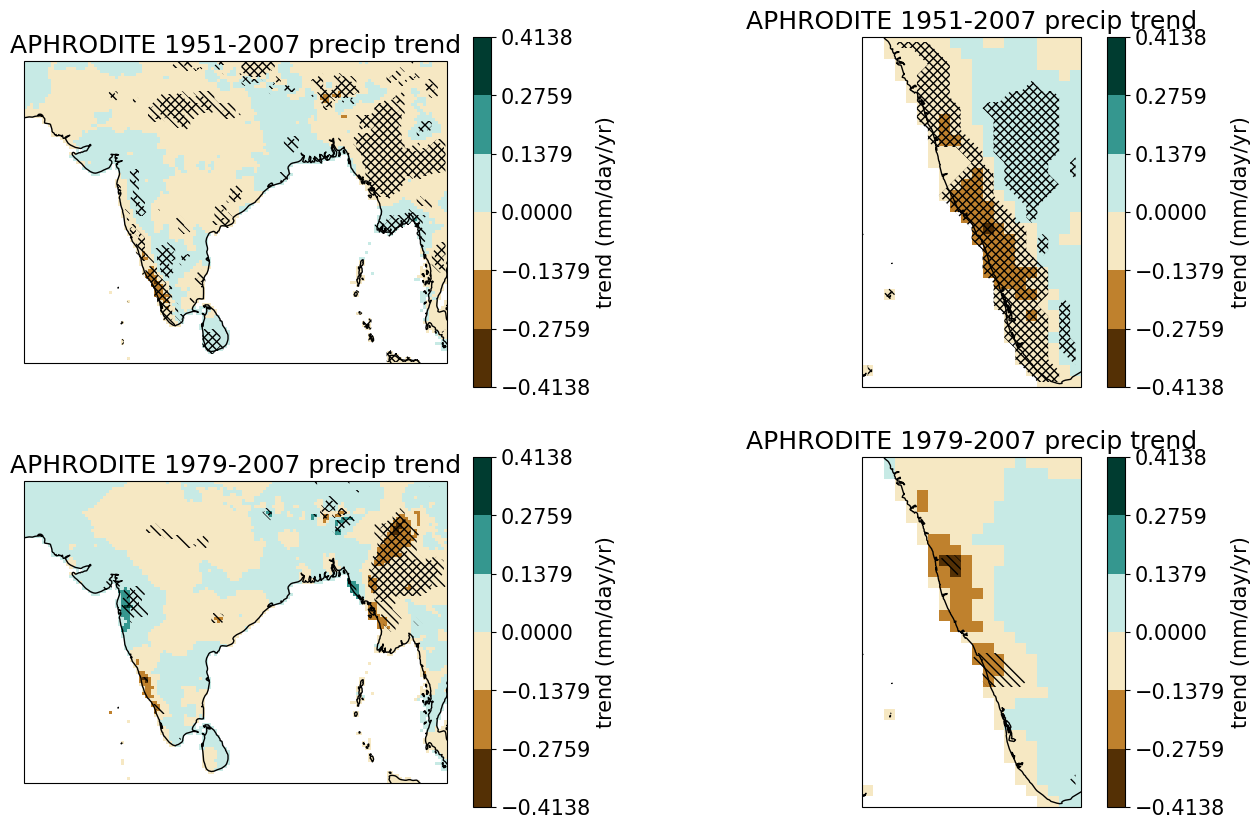

In [131]:
_,axss=plt.subplots(2,2,figsize=(15,10),subplot_kw={'projection':ccrs.PlateCarree()})
for axs,yrs in zip(axss,((1951,2007),(1979,2007))):
    plot_trend_fdr(axs[1],APHRODITE.precip_jja_yearly.sel(year=slice(*yrs)).sel(latitude=slice(16,8),longitude=slice(73,78)))
    plot_trend_fdr(axs[0],APHRODITE.precip_jja_yearly.sel(year=slice(*yrs)).sel(latitude=slice(30,5),longitude=slice(65,100)))
    for ax in axs:
        ax.coastlines()
        ax.set_title('APHRODITE %i-%i precip trend'%yrs)

# Trend maps

## Long-term trend maps

In [132]:
def plot_trend_fdr(ax,ds,dim='year', units = 'mm/day/yr', sig_level=0.1):
    reg = linregress_xr(ds[dim],ds,dim)
    reg.slope.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={'label':'trend (%s)'%units},cmap = plt.cm.BrBG,levels=np.linspace(-0.25,0.25,11),extend='both')
    fdrmask = fdr_xr_2d(reg.pvalue,sig_level)
    #fdrmask = reg.pvalue.longitude < 100
    (reg.pvalue**0*fdrmask).plot.contourf(ax=ax,levels=[0,0.5],hatches=[None,'////'],colors='none',add_colorbar=False)
    

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 1.0, 'IMD 1901-2022 precip trend')

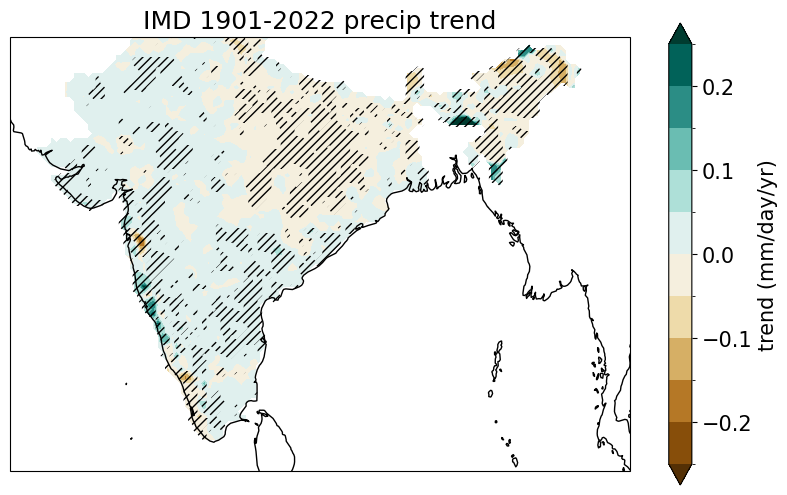

In [133]:
_,ax=plt.subplots(1,1,figsize=(10,6),subplot_kw={'projection':ccrs.PlateCarree()})
dataset=IMD
plot_trend_fdr(ax,dataset.precip_jja_yearly)
ax.coastlines()
ax.set_title('%s %i-%i precip trend'%(dataset.name,*dataset.jja_time_range))

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


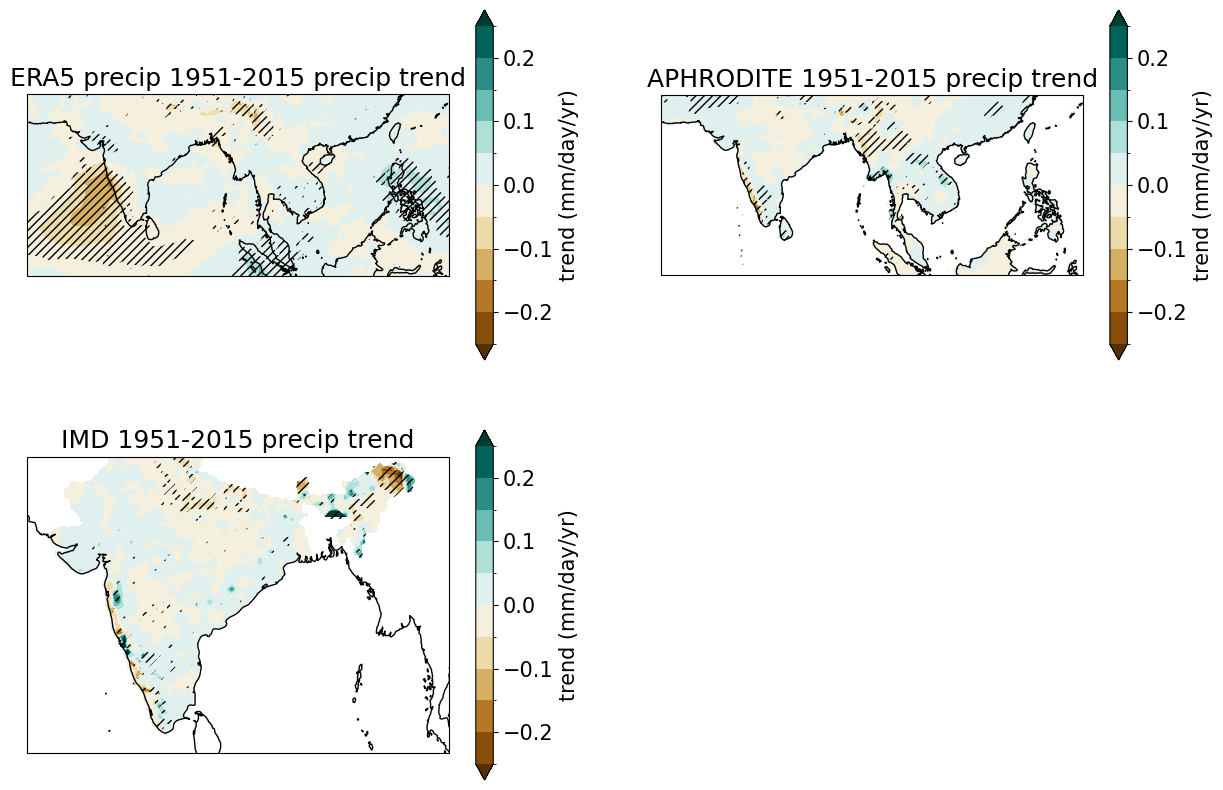

In [134]:
_,axs=plt.subplots(2,2,figsize=(15,10),subplot_kw={'projection':ccrs.PlateCarree()})
axs=axs.reshape(-1)
for ax,dataset in zip(axs,(ERA5,APHRODITE,IMD)):
    yrs = (1951,2015)
    plot_trend_fdr(ax,dataset.precip_jja_yearly.sel(year=slice(*yrs)).sel(longitude=slice(60,130)))
    ax.coastlines()
    ax.set_title('%s %i-%i precip trend'%(dataset.name,*yrs))
axs[-1].remove()

## Medium-term trend maps

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputil

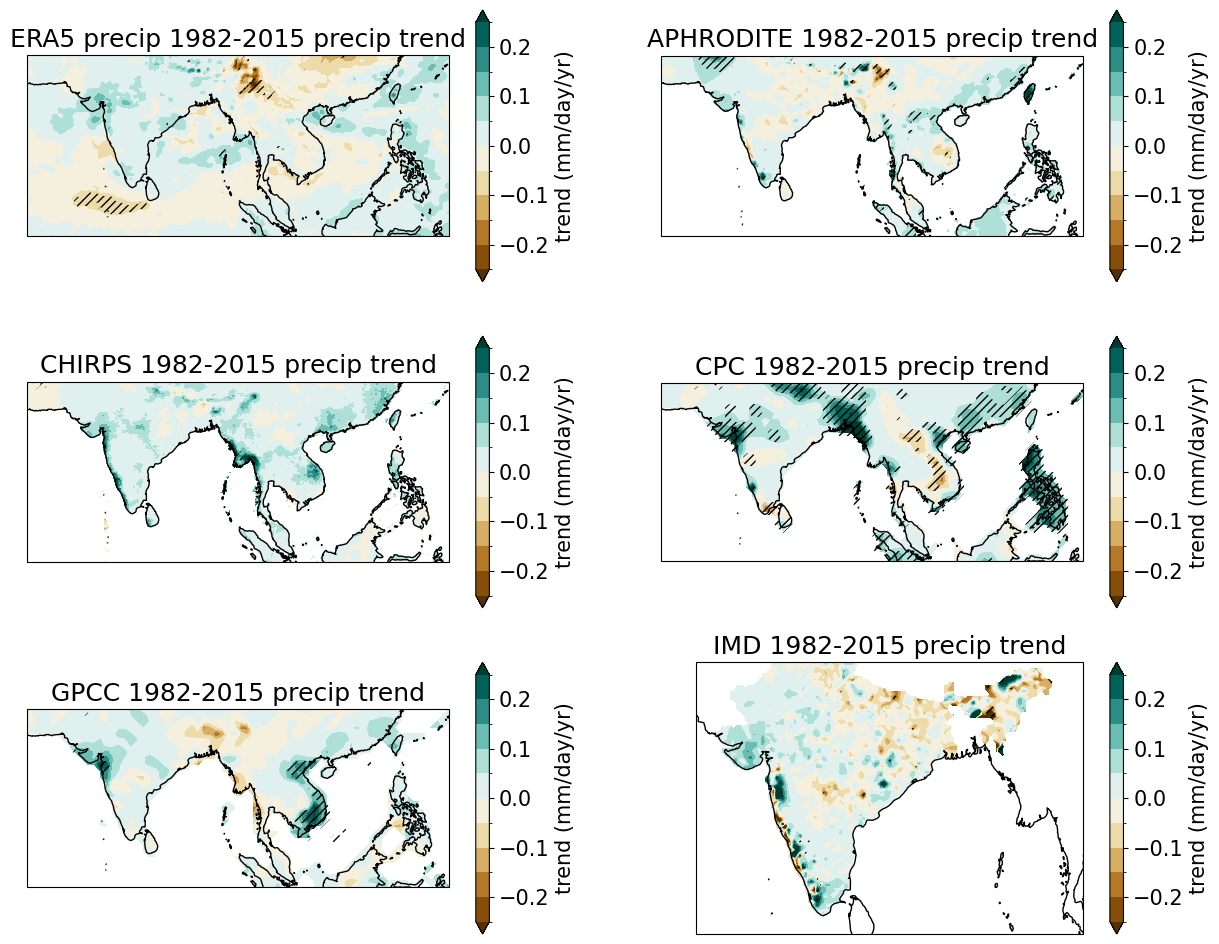

In [135]:
_,axs=plt.subplots(3,2,figsize=(15,12),subplot_kw={'projection':ccrs.PlateCarree()})
axs=axs.reshape(-1)
for ax,dataset in zip(axs,(ERA5,APHRODITE,CHIRPS,CPC,GPCC,IMD)):
    yrs = (1982,2015)
    plot_trend_fdr(ax,dataset.precip_jja_yearly.sel(year=slice(*yrs)).sel(longitude=slice(60,130)))
    ax.coastlines()
    ax.set_title('%s %i-%i precip trend'%(dataset.name,*yrs))

## Short-term trend maps

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


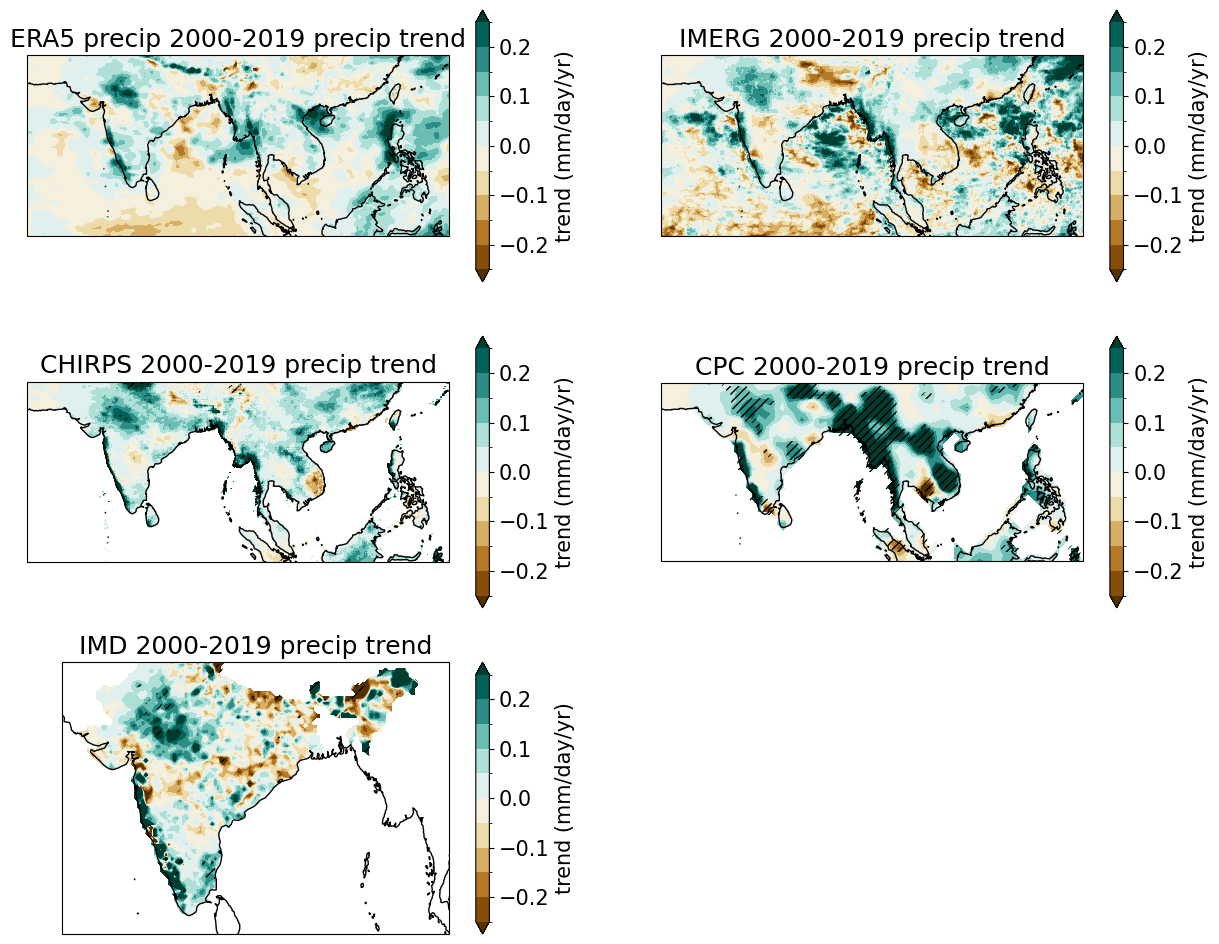

In [136]:
_,axs=plt.subplots(3,2,figsize=(15,12),subplot_kw={'projection':ccrs.PlateCarree()})
axs=axs.reshape(-1)
for ax,dataset in zip(axs,(ERA5,IMERG,CHIRPS,CPC,IMD)):
    yrs = (2000,2019)
    plot_trend_fdr(ax,dataset.precip_jja_yearly.sel(year=slice(*yrs)).sel(longitude=slice(60,130)))
    ax.coastlines()
    ax.set_title('%s %i-%i precip trend'%(dataset.name,*yrs))
axs[-1].remove()

# Wind changes from ERA5

In [17]:
%%time
e5_100u_1979_2020 = e5_monthly_timeseries('228_246_100u',range(1979,2021))
e5_100v_1979_2020 = e5_monthly_timeseries('228_247_100v',range(1979,2021))
e5_100u_1950_1978 = e5_monthly_timeseries('228_246_100u',range(1950,1979))
e5_100v_1950_1978 = e5_monthly_timeseries('228_247_100v',range(1950,1979))

11.605271100997925
12.107117891311646
1.8917996883392334
1.9477832317352295
CPU times: user 40.3 s, sys: 30 s, total: 1min 10s
Wall time: 31.1 s


In [18]:
e5_100u_monthly = xr.concat((e5_100u_1950_1978,e5_100u_1979_2020),dim='time')
e5_100v_monthly = xr.concat((e5_100v_1950_1978,e5_100v_1979_2020),dim='time')
e5_100u_jja_yearly = sel_box_months(e5_100u_monthly,box = box, months=months).groupby('time.year').mean().load()
e5_100v_jja_yearly = sel_box_months(e5_100v_monthly,box = box, months=months).groupby('time.year').mean().load()

In [19]:
e5_crossslopeu_jja_yearly = crossslopeflow(e5_100u_jja_yearly,e5_100v_jja_yearly,70)
e5_crossslopeum_jja_yearly = crossslopeflow(e5_100u_jja_yearly,e5_100v_jja_yearly,60)

e5_windspeed_jja_yearly   = np.sqrt(e5_100u_jja_yearly**2+e5_100v_jja_yearly**2)

In [20]:
e5_100u_ond_yearly = sel_box_months(e5_100u_monthly,box = box, months=[10,11,12]).groupby('time.year').mean().load()
e5_100v_ond_yearly = sel_box_months(e5_100v_monthly,box = box, months=[10,11,12]).groupby('time.year').mean().load()
e5_crossslopeu_ond_yearly = crossslopeflow(e5_100u_ond_yearly,e5_100v_ond_yearly,250)


In [21]:
windmask = tilted_rect(e5_crossslopeu_jja_yearly,*ghats_tilted_rect,reverse=True)
windmask_myanmar = tilted_rect(e5_crossslopeu_jja_yearly,*[96.5 ,  12  ,  91  , 21   ,2],reverse=True)
windmask_philippines = tilted_rect(e5_crossslopeu_jja_yearly,*[122  ,  9 ,118.5,  19    ,2],reverse=True)
windmask_vietnam = tilted_rect(e5_crossslopeu_jja_yearly,*[108  ,  18  , 111  , 13   ,2],reverse=True)

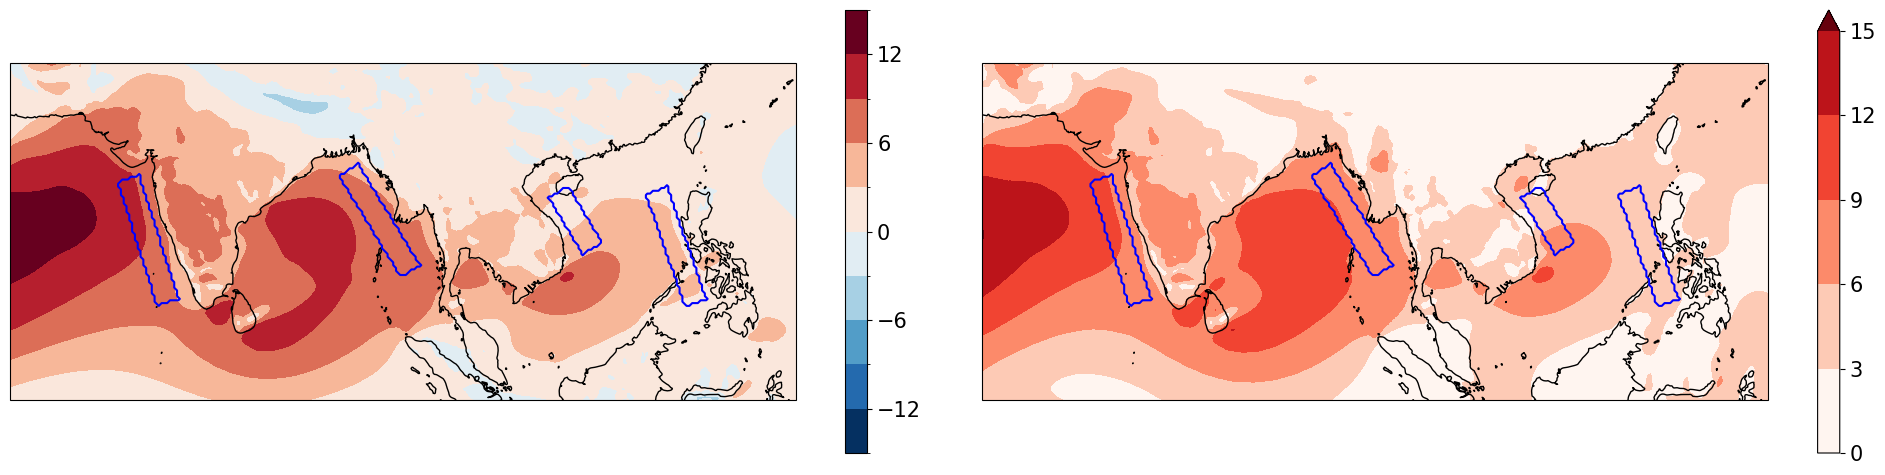

In [22]:
fig,axs=plt.subplots(1,2,figsize=(20,5),subplot_kw={'projection':ccrs.PlateCarree()})
e5_crossslopeu_jja_yearly.sel(longitude=slice(60,130)).mean('year').plot.contourf(ax=axs[0],transform=ccrs.PlateCarree(),levels=np.linspace(-15,15,11))
e5_windspeed_jja_yearly  .sel(longitude=slice(60,130)).mean('year').plot.contourf(ax=axs[1],transform=ccrs.PlateCarree(),levels=np.linspace(0,15,6),cmap=plt.cm.Reds)
for ax in axs:
    ax.coastlines()
    windmask            .sel(longitude=slice(60,130)).plot.contour(ax=ax,levels=[0.5],colors='b',transform=ccrs.PlateCarree())
    windmask_myanmar    .sel(longitude=slice(60,130)).plot.contour(ax=ax,levels=[0.5],colors='b',transform=ccrs.PlateCarree())
    windmask_philippines.sel(longitude=slice(60,130)).plot.contour(ax=ax,levels=[0.5],colors='b',transform=ccrs.PlateCarree())
    windmask_vietnam.sel(longitude=slice(60,130)).plot.contour(ax=ax,levels=[0.5],colors='b',transform=ccrs.PlateCarree())
fig.tight_layout()

Correlation coef, ERA5 precip: 0.16 / 0.02
Correlation coef, APHRODITE: 0.40 / 0.27
Correlation coef, IMD: 0.48 / 0.35


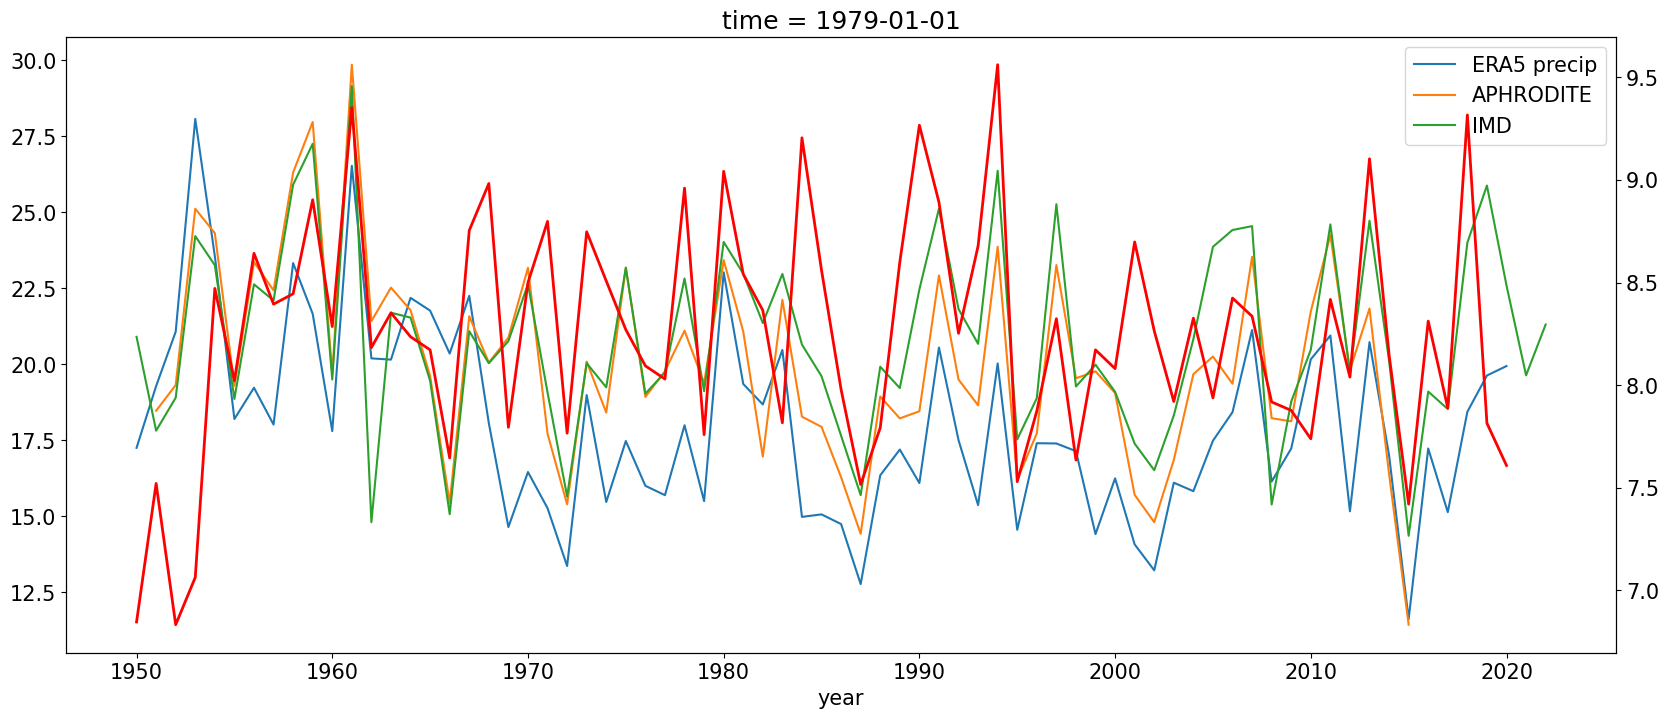

In [24]:
fig,ax=plt.subplots(1,1,figsize=(20,8))
wind_ts = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask)
wind_ts2 = spatial_mean(e5_windspeed_jja_yearly,mask = windmask)
for dataset in (ERA5,APHRODITE,IMD):
    precip_ts = spatial_mean(dataset.precip_jja_yearly,mask = dataset.ghats_mask).sel(year=slice(1950,2022))
    precip_ts.plot(ax=ax,label=dataset.name)
    corrcoef = np.corrcoef(wind_ts.sel(year=slice(*dataset.jja_time_range)),precip_ts.sel(year=slice(1950,2020)))[0,1]
    corrcoef2 = np.corrcoef(wind_ts2.sel(year=slice(*dataset.jja_time_range)),precip_ts.sel(year=slice(1950,2020)))[0,1]
    print("Correlation coef, %s: %.2f / %.2f"%(dataset.name,corrcoef,corrcoef2))
ax.legend()
ax2=ax.twinx()
wind_ts.plot(ax=ax2,label=dataset.name,color='r',linewidth=2)


# Regressing wind on precip

In [25]:
def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=100,app='/(m/s2)',pos=(0.87,1.03)):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=5
    m=5
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label='', labelpos='E', coordinates='axes',color='k',angle=90)
    return q

Text(0.5, 0.98, 'Wind regressed on Ghats precip')

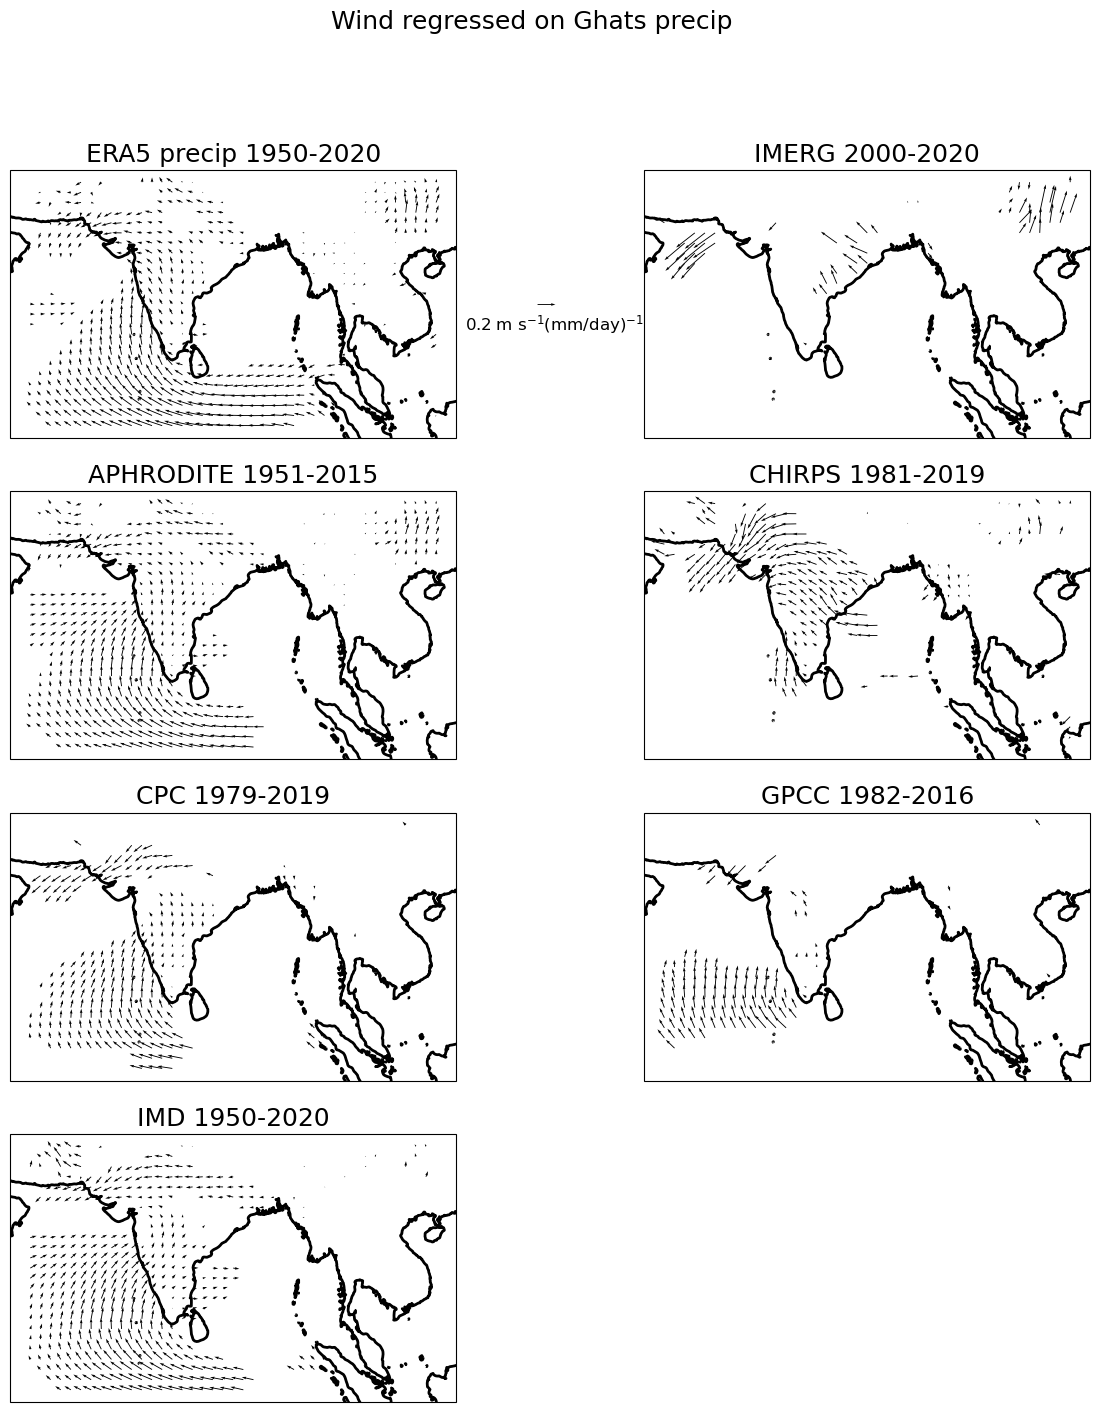

In [26]:
fig,axs=plt.subplots(4,2,figsize=(15,16),subplot_kw={'projection':ccrs.PlateCarree()})
axs=axs.reshape(-1)
flag=1
for ax,dataset in zip(axs,(ERA5,IMERG,APHRODITE,CHIRPS,CPC,GPCC,IMD)):
    precip_ts = spatial_mean(dataset.precip_jja_yearly,mask = dataset.ghats_mask).sel(year=slice(1950,2020))
    u_sub = e5_100u_jja_yearly.sel(year=slice(*dataset.jja_time_range)).sel(longitude=slice(60,110))
    v_sub = e5_100v_jja_yearly.sel(year=slice(*dataset.jja_time_range)).sel(longitude=slice(60,110))

    ureg = linregress_xr(precip_ts,u_sub,dim='year')
    vreg = linregress_xr(precip_ts,v_sub,dim='year')
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1) + fdr_xr_2d(vreg.pvalue,0.1) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    if flag:
        Q = add_wind(ax,u,v,color='k',width=0.002,scale=5,key=False)
        flag=0
    else:
        add_wind(ax,u,v,color='k',width=0.002,scale=5,key=False)
    ax.coastlines(linewidth=2)
    yrs = float(precip_ts.year.min()),float(precip_ts.year.max())
    
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
    #add_latlon(ax,MR.box,ftz=14)
axs[-1].remove()

# Quiver key (reference wind arrow)
qk = axs[0].quiverkey(Q, 1.2, 0.5, 0.2,label='', labelpos='N',
                   coordinates='axes',color='k')
axs[0].text(1.02, 0.4, r'0.2 m s$^{-1}$(mm/day)$^{-1}$',fontsize=12,transform=axs[0].transAxes,color='k')
fig.suptitle("Wind regressed on Ghats precip")

Text(0.5, 0.98, 'Cross-slope wind regressed on Ghats precip')

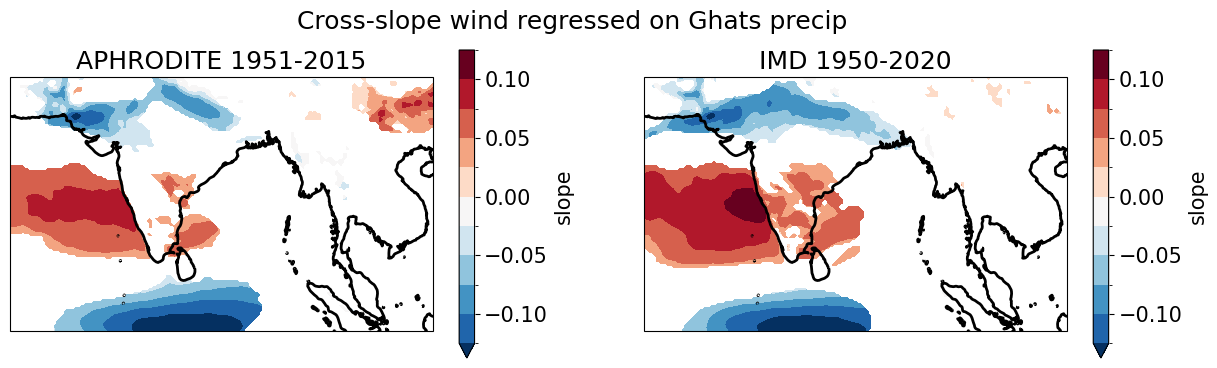

In [27]:
fig,axs=plt.subplots(1,2,figsize=(15,4),subplot_kw={'projection':ccrs.PlateCarree()})
for ax,dataset in zip(axs,(APHRODITE,IMD)):
    precip_ts = spatial_mean(dataset.precip_jja_yearly,mask = dataset.ghats_mask).sel(year=slice(1950,2020))
    u_sub = e5_crossslopeu_jja_yearly.sel(year=slice(*dataset.jja_time_range)).sel(longitude=slice(60,110))
    
    ureg = linregress_xr(precip_ts,u_sub,dim='year')
    fdrfact = fdr_xr_2d(ureg.pvalue,0.1)
    u = ureg.slope /fdrfact
    u.plot.contourf(ax=ax,levels=np.linspace(-0.125,0.125,11))
    ax.coastlines(linewidth=2)
    yrs = float(precip_ts.year.min()),float(precip_ts.year.max())
    
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
fig.suptitle("Cross-slope wind regressed on Ghats precip")

# Regressing precip on wind

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 0.98, 'Precip regressed on upstream cross-slope wind ((mm/day)/(m/s))')

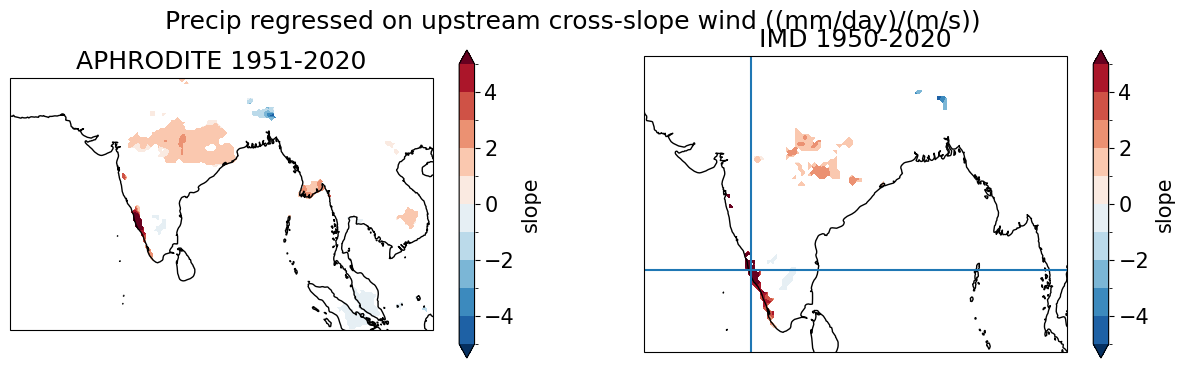

In [30]:
fig,axs=plt.subplots(1,2,figsize=(15,4),subplot_kw={'projection':ccrs.PlateCarree()})

for ax,dataset in zip(axs,(APHRODITE,IMD)):
    wind_ts = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask).sel(year=slice(*dataset.jja_time_range))
    precip = dataset.precip_jja_yearly.sel(year=slice(1950,2020),longitude=slice(60,110))
    precip_reg = linregress_xr(wind_ts,precip,dim='year')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1)
    (precip_reg.slope /fdrfact).plot.contourf(ax=ax,levels=np.linspace(-5,5,11))
    ax.coastlines(linewidth=1)
    yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
axs[1].axhline(13)
axs[1].axvline(75)
fig.suptitle("Precip regressed on upstream cross-slope wind ((mm/day)/(m/s))")

Text(0, 0.5, 'precip (mm/day)')

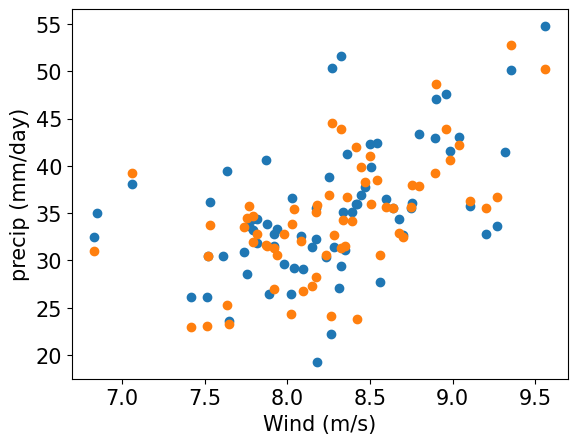

In [31]:
precip = IMD.precip_jja_yearly.sel(longitude=75,latitude=13,method='nearest').sel(year=slice(1950,2020))
wind_ts = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask).sel(year=slice(*IMD.jja_time_range))

precip2 = APHRODITE.precip_jja_yearly.sel(longitude=75,latitude=13,method='nearest').sel(year=slice(1950,2020))
wind_ts2 = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask).sel(year=slice(*APHRODITE.jja_time_range))


plt.scatter(wind_ts,precip)
plt.scatter(wind_ts2,precip2)
plt.xlabel("Wind (m/s)")
plt.ylabel("precip (mm/day)")

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 0.98, 'Precip regressed on upstream cross-slope wind (%/(m/s))')

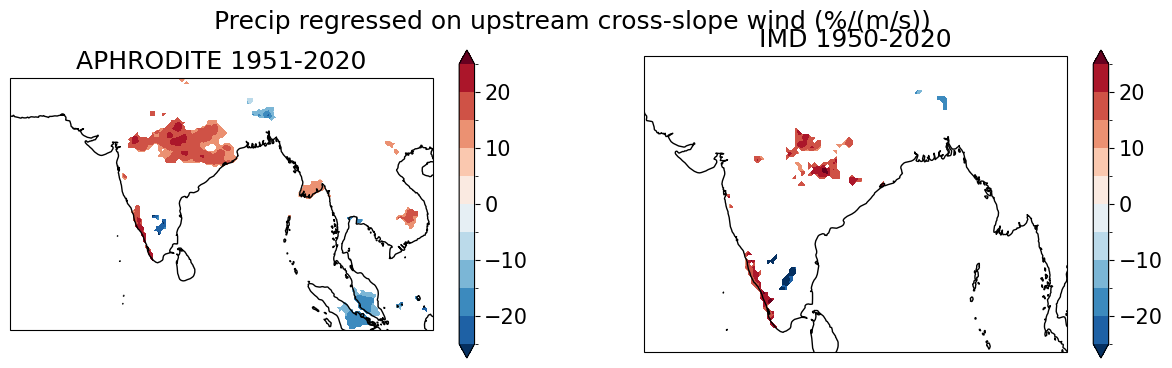

In [37]:
fig,axs=plt.subplots(1,2,figsize=(15,4),subplot_kw={'projection':ccrs.PlateCarree()})

for ax,dataset in zip(axs,(APHRODITE,IMD)):
    wind_ts = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask).sel(year=slice(*dataset.jja_time_range))
    precip = dataset.precip_jja_yearly.sel(year=slice(1950,2020),longitude=slice(60,110))
    precip_reg = linregress_xr(wind_ts,precip,dim='year')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1)
    (100*precip_reg.slope /fdrfact/precip.mean('year')).plot.contourf(ax=ax,levels=np.linspace(-25,25,11),extend='both')
    ax.coastlines(linewidth=1)
    yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
fig.suptitle("Precip regressed on upstream cross-slope wind (%/(m/s))")

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 0.98, 'Precip regressed on upstream cross-slope wind (%/(m/s))')

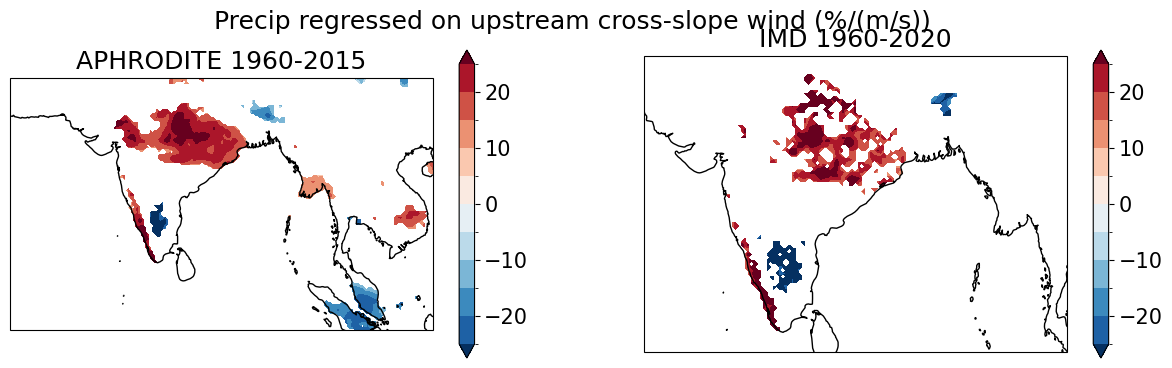

In [23]:
fig,axs=plt.subplots(1,2,figsize=(15,4),subplot_kw={'projection':ccrs.PlateCarree()})

for ax,dataset in zip(axs,(APHRODITE,IMD)):
    wind_ts = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask).sel(year=slice(*dataset.jja_time_range)).sel(year=slice(1960,2020))
    precip = dataset.precip_jja_yearly.sel(year=slice(1960,2020),longitude=slice(60,110))
    precip_reg = linregress_xr(wind_ts,precip,dim='year')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1)
    (100*precip_reg.slope /fdrfact/precip.mean('year')).plot.contourf(ax=ax,levels=np.linspace(-25,25,11),extend='both')
    ax.coastlines(linewidth=1)
    yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
fig.suptitle("Precip regressed on upstream cross-slope wind (%/(m/s))")

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


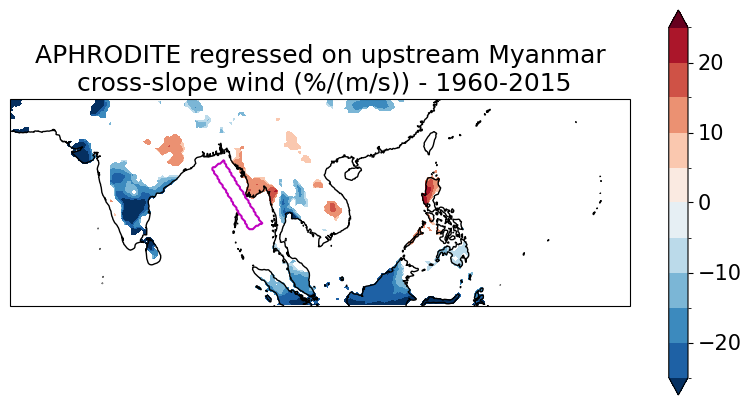

In [40]:
fig,ax=plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs=(ax,)
for ax,dataset in zip(axs,(APHRODITE,)):
    wind_ts = spatial_mean(e5_crossslopeum_jja_yearly,mask = windmask_myanmar).sel(year=slice(*dataset.jja_time_range)).sel(year=slice(1960,2020))
    precip = dataset.precip_jja_yearly.sel(year=slice(1960,2020))
    precip_reg = linregress_xr(wind_ts,precip,dim='year')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1)
    (100*precip_reg.slope /fdrfact/precip.mean('year')).plot.contourf(ax=ax,levels=np.linspace(-25,25,11))
    ax.coastlines(linewidth=1)
    yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
    windmask_myanmar.plot.contour(ax=ax,levels=[0.5],colors='m',transform=ccrs.PlateCarree())
    ax.set_title("%s regressed on upstream Myanmar\n cross-slope wind (%%/(m/s)) - %i-%i"%(dataset.name,*yrs))
    

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


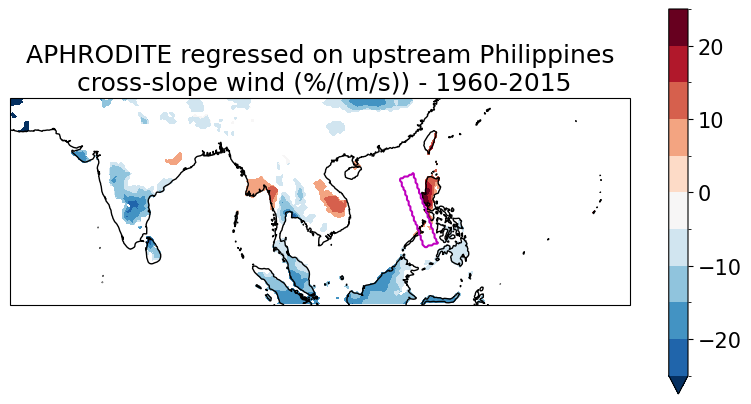

In [41]:
fig,ax=plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs=(ax,)
for ax,dataset in zip(axs,(APHRODITE,)):
    wind_ts = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask_philippines).sel(year=slice(*dataset.jja_time_range)).sel(year=slice(1960,2020))
    precip = dataset.precip_jja_yearly.sel(year=slice(1960,2020))
    precip_reg = linregress_xr(wind_ts,precip,dim='year')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1)
    (100*precip_reg.slope /fdrfact/precip.mean('year')).plot.contourf(ax=ax,levels=np.linspace(-25,25,11))
    ax.coastlines(linewidth=1)
    yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
    windmask_philippines.plot.contour(ax=ax,levels=[0.5],colors='m',transform=ccrs.PlateCarree())
    ax.set_title("%s regressed on upstream Philippines\n cross-slope wind (%%/(m/s)) - %i-%i"%(dataset.name,*yrs))
    

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


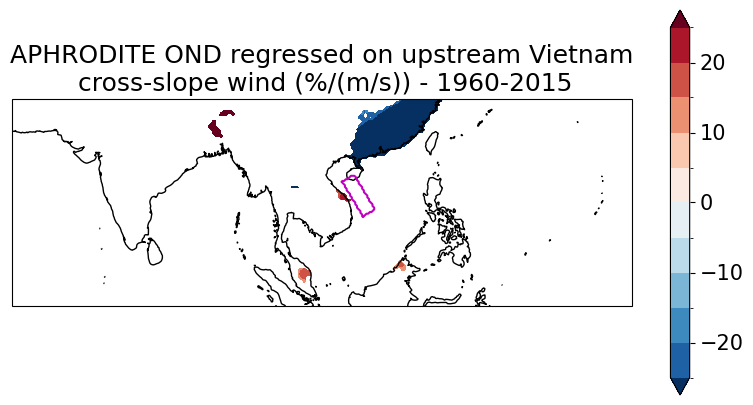

In [24]:
fig,ax=plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs=(ax,)
for ax,dataset in zip(axs,(APHRODITE,)):
    wind_ts = spatial_mean(e5_crossslopeu_ond_yearly,mask = windmask_vietnam).sel(year=slice(*dataset.ond_time_range)).sel(year=slice(1960,2020))
    precip = dataset.precip_ond_yearly.sel(year=slice(1960,2020))
    precip_reg = linregress_xr(wind_ts,precip,dim='year')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1)
    (100*precip_reg.slope /fdrfact/precip.mean('year')).plot.contourf(ax=ax,levels=np.linspace(-25,25,11))
    ax.coastlines(linewidth=1)
    yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
    windmask_vietnam.plot.contour(ax=ax,levels=[0.5],colors='m',transform=ccrs.PlateCarree())
    ax.set_title("%s OND regressed on upstream Vietnam\n cross-slope wind (%%/(m/s)) - %i-%i"%(dataset.name,*yrs))
    

# Precip on local wind speed

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 0.98, 'Precip regressed on local wind speed ((mm/day)/(m/s))')

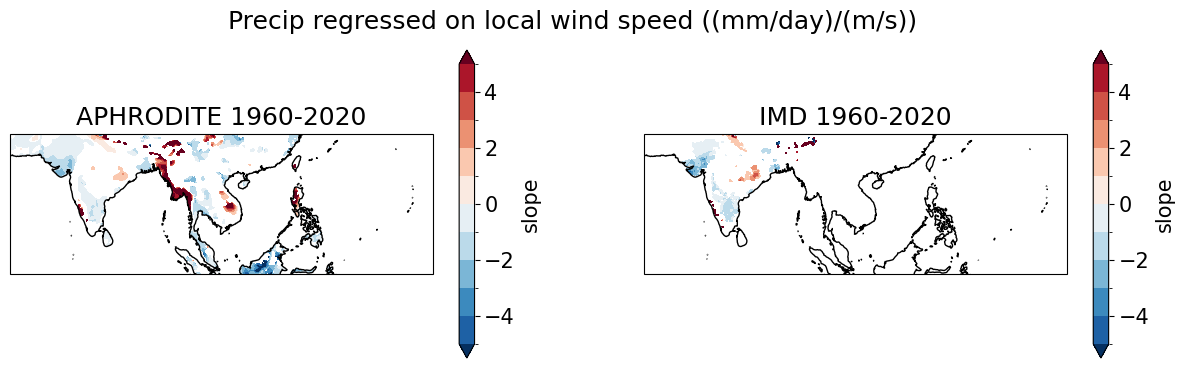

In [42]:
fig,axs=plt.subplots(1,2,figsize=(15,4),subplot_kw={'projection':ccrs.PlateCarree()})

for ax,dataset in zip(axs,(APHRODITE,IMD)):
    wind = e5_windspeed_jja_yearly.sel(year=slice(*dataset.jja_time_range)).sel(year=slice(1960,2020))
    precip = dataset.precip_jja_yearly.sel(year=slice(1960,2020)).interp_like(wind)
    precip_reg = linregress_xr(wind,precip,dim='year')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1)
    (precip_reg.slope /fdrfact).plot.contourf(ax=ax,levels=np.linspace(-5,5,11),extend='both')
    ax.coastlines(linewidth=1)
    yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
fig.suptitle("Precip regressed on local wind speed ((mm/day)/(m/s))")

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 0.98, 'Precip regressed on local wind speed ((mm/day)/(m/s))')

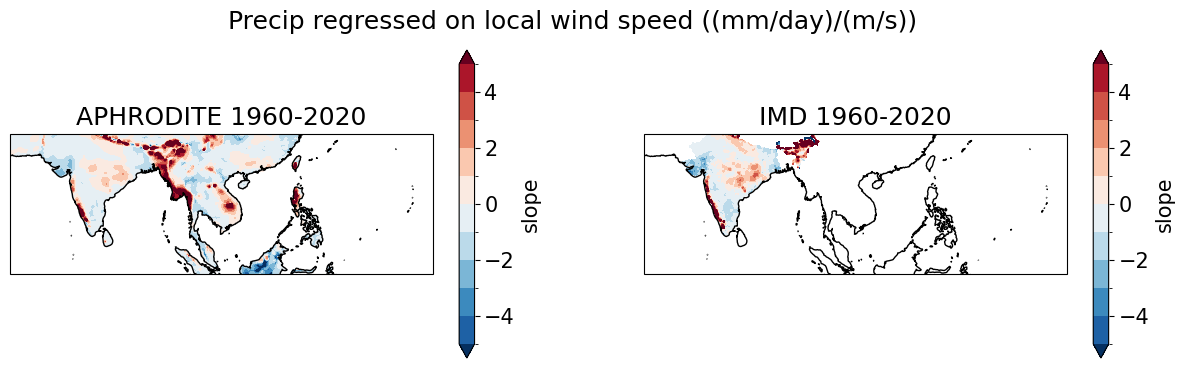

In [43]:
fig,axs=plt.subplots(1,2,figsize=(15,4),subplot_kw={'projection':ccrs.PlateCarree()})

for ax,dataset in zip(axs,(APHRODITE,IMD)):
    wind = e5_windspeed_jja_yearly.sel(year=slice(*dataset.jja_time_range)).sel(year=slice(1960,2020))
    precip = dataset.precip_jja_yearly.sel(year=slice(1960,2020)).interp_like(wind)
    precip_reg = linregress_xr(wind,precip,dim='year')
    fdrfact = 1.#fdr_xr_2d(precip_reg.pvalue,0.1)
    (precip_reg.slope /fdrfact).plot.contourf(ax=ax,levels=np.linspace(-5,5,11),extend='both')
    ax.coastlines(linewidth=1)
    yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
fig.suptitle("Precip regressed on local wind speed ((mm/day)/(m/s))")

# SST regressions

In [48]:
%%time
e5_sst_1979_2020 = e5_monthly_timeseries('128_034_sstk',range(1979,2021))
e5_sst_1950_1978 = e5_monthly_timeseries('128_034_sst',range(1950,1979))

7.4099695682525635
1.4139490127563477
CPU times: user 13.8 s, sys: 11.5 s, total: 25.3 s
Wall time: 10.2 s


In [49]:
e5_sst_monthly = xr.concat((e5_sst_1950_1978,e5_sst_1979_2020),dim='time')
e5_sst_jja_yearly = sel_box_months(e5_sst_monthly,box = box, months=months).groupby('time.year').mean().load()

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 0.98, 'SST regressed on Ghats precip - nothing passes FDR')

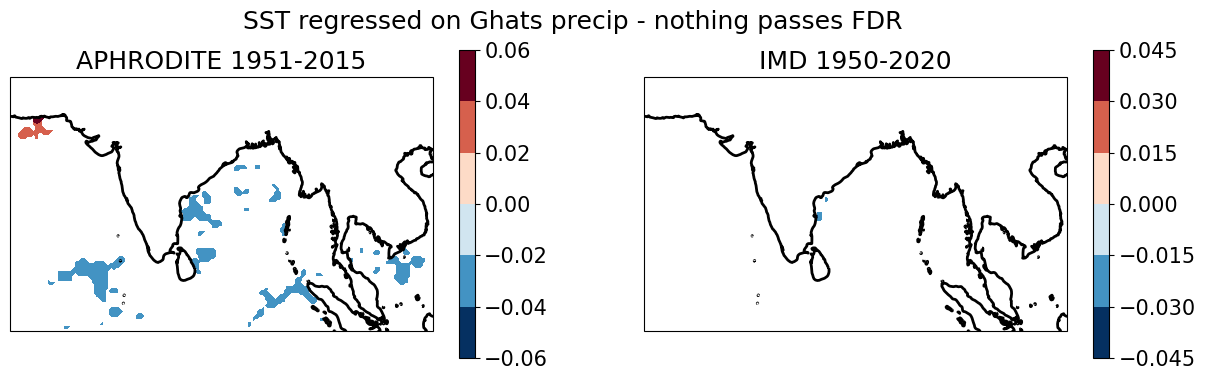

In [72]:
fig,axs=plt.subplots(1,2,figsize=(15,4),subplot_kw={'projection':ccrs.PlateCarree()})
for ax,dataset in zip(axs,(APHRODITE,IMD)):
    precip_ts = spatial_mean(dataset.precip_jja_yearly,mask = dataset.ghats_mask).sel(year=slice(1950,2020))
    sst_sub = e5_sst_jja_yearly.sel(year=slice(*dataset.jja_time_range)).sel(longitude=slice(60,110))
    
    sstreg = linregress_xr(precip_ts,sst_sub,dim='year')
    fdrfact = sstreg.pvalue<0.05#fdr_xr_2d(sstreg.pvalue,0.1)
    sstr = sstreg.slope /fdrfact
    sstr.plot.contourf(ax=ax)
    ax.coastlines(linewidth=2)
    yrs = float(precip_ts.year.min()),float(precip_ts.year.max())
    
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
fig.suptitle("SST regressed on Ghats precip - nothing passes FDR")

/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/global/common/software/m3310/conda/xrdask.2023.11.qn/lib/python3.9/site-packages/xarray/core/nputils.py:177: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


Text(0.5, 0.98, 'SST regressed on central India precip')

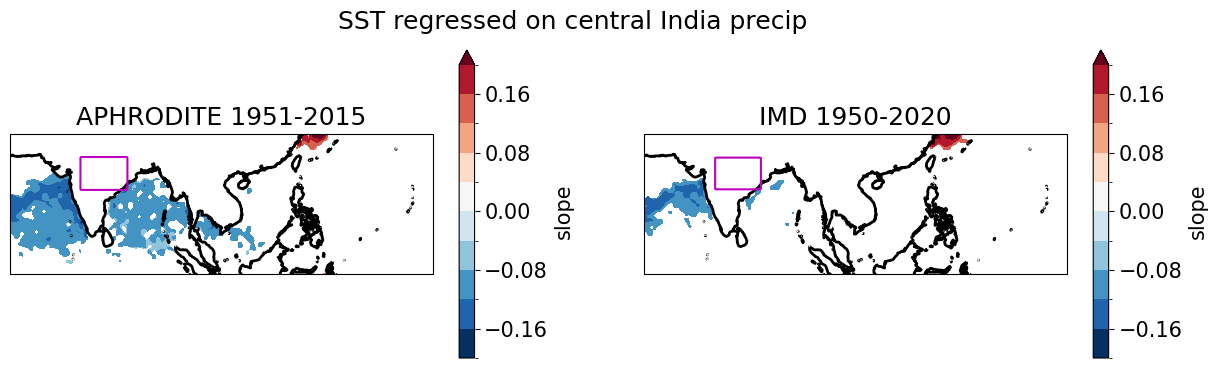

In [70]:
fig,axs=plt.subplots(1,2,figsize=(15,4),subplot_kw={'projection':ccrs.PlateCarree()})
for ax,dataset in zip(axs,(APHRODITE,IMD)):
    mask_ = (dataset.ghats_mask.latitude>18)*(dataset.ghats_mask.latitude<25)*(dataset.ghats_mask.longitude>75)*(dataset.ghats_mask.longitude<85)
    precip_ts = spatial_mean(dataset.precip_jja_yearly,mask = mask_).sel(year=slice(1950,2020))
    sst_sub = e5_sst_jja_yearly.sel(year=slice(*dataset.jja_time_range))
    
    sstreg = linregress_xr(precip_ts,sst_sub,dim='year')
    fdrfact = fdr_xr_2d(sstreg.pvalue,0.1)
    sstr = sstreg.slope /fdrfact
    sstr.plot.contourf(ax=ax,levels=np.linspace(-0.2,0.2,11))
    ax.coastlines(linewidth=2)
    yrs = float(precip_ts.year.min()),float(precip_ts.year.max())
    
    mask_.plot.contour(ax=ax,levels=[0.5],colors='m',transform=ccrs.PlateCarree())
    
    ax.set_title('%s %i-%i'%(dataset.name,*yrs))
fig.suptitle("SST regressed on central India precip")

# T&q regressed on wind & precip

In [100]:
#%%time
## Run a cluster to speed things up
#e5_t_1950_1978 = e5_monthly_timeseries('128_130_t',range(1950,1979),box = [60,110,0,30])
#e5_t_1979_2020 = e5_monthly_timeseries('128_130_t',range(1979,2021),box = [60,110,0,30])
#e5_q_1950_1978 = e5_monthly_timeseries('128_133_q',range(1950,1979),box = [60,110,0,30])
#e5_q_1979_2020 = e5_monthly_timeseries('128_133_q',range(1979,2021),box = [60,110,0,30])
e5_t_1950_1978 = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/e5.monthly.128_130_t.1950-1978.zarr").t
e5_t_1979_2020 = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/e5.monthly.128_130_t.1979-2020.zarr").T
e5_q_1950_1978 = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/e5.monthly.128_133_q.1950-1978.zarr").q
e5_q_1979_2020 = xr.open_zarr("/pscratch/sd/q/qnicolas/temp/e5.monthly.128_133_q.1979-2020.zarr").Q

In [101]:
e5_t_monthly = xr.concat((e5_t_1950_1978,e5_t_1979_2020),dim='time')
e5_q_monthly = xr.concat((e5_q_1950_1978,e5_q_1979_2020),dim='time')

In [104]:
%%time
e5_tL_jja_yearly = (sel_months(e5_t_monthly, months=months).groupby('time.year').mean().sel(level=slice(700,900)).integrate('level')/300).load()
e5_qL_jja_yearly = (sel_months(e5_q_monthly, months=months).groupby('time.year').mean().sel(level=slice(700,900)).integrate('level')/300).load()


CPU times: user 1.25 s, sys: 285 ms, total: 1.53 s
Wall time: 3.37 s


Text(0.5, 1.0, 'T_L regressed on upstream cross-slope wind 1960-2020')

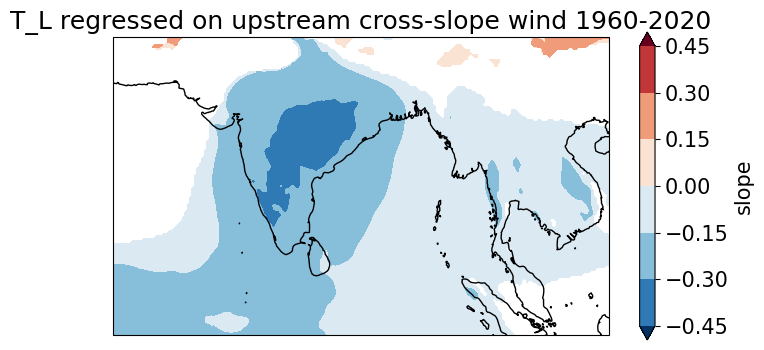

In [105]:
fig,ax=plt.subplots(1,1,figsize=(8,4),subplot_kw={'projection':ccrs.PlateCarree()})

wind_ts = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask).sel(year=slice(1960,2020))
temp = e5_tL_jja_yearly.sel(year=slice(1960,2020))
reg = linregress_xr(wind_ts,temp,dim='year')
fdrfact = fdr_xr_2d(reg.pvalue,0.1)
(reg.slope /fdrfact).plot.contourf(ax=ax,extend='both')#,levels=np.linspace(-25,25,11)
ax.coastlines(linewidth=1)
yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
ax.set_title("T_L regressed on upstream cross-slope wind %i-%i"%yrs)

Text(0.5, 1.0, 'q_L regressed on upstream cross-slope wind 1960-2020')

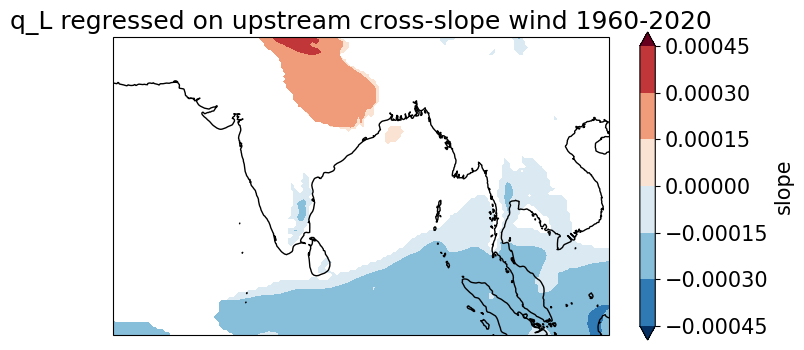

In [108]:
fig,ax=plt.subplots(1,1,figsize=(8,4),subplot_kw={'projection':ccrs.PlateCarree()})

wind_ts = spatial_mean(e5_crossslopeu_jja_yearly,mask = windmask).sel(year=slice(1960,2020))
temp = e5_qL_jja_yearly.sel(year=slice(1960,2020))
reg = linregress_xr(wind_ts,temp,dim='year')
fdrfact = fdr_xr_2d(reg.pvalue,0.1)
(reg.slope /fdrfact).plot.contourf(ax=ax,extend='both')#,levels=np.linspace(-25,25,11)
ax.coastlines(linewidth=1)
yrs = float(wind_ts.year.min()),float(wind_ts.year.max())
ax.set_title("q_L regressed on upstream cross-slope wind %i-%i"%yrs)

# Model sensitivities vs U

In [17]:
from orographicConvectionTheory.orographicConvectionTheory import topographic_profile, smith_theory, linear_precip_theory

In [118]:
Us = np.arange(8,14.1,0.5)
dPdUs_NB22 = np.zeros(len(Us))
dPdUs_NB22_nolq = np.zeros(len(Us))
dPdUs_NB22_lowtscales = np.zeros(len(Us))
dPdUs_SB04 = np.zeros(len(Us))
eps=0.1

for i,U in enumerate(Us):
    testP  = linear_precip_theory(*topographic_profile('cos'),U-eps,P0=4,tauT=7.5,tauq=27.5)
    testP2 = linear_precip_theory(*topographic_profile('cos'),U+eps,P0=4,tauT=7.5,tauq=27.5)
    dPdUs_NB22[i] = ((testP2.max()-4)/(testP.max()-4)-1)/eps/2
    
    testP  = linear_precip_theory(*topographic_profile('cos'),U-eps,P0=4,tauT=3,tauq=11)
    testP2 = linear_precip_theory(*topographic_profile('cos'),U+eps,P0=4,tauT=3,tauq=11)
    dPdUs_NB22_lowtscales[i] = ((testP2.max()-4)/(testP.max()-4)-1)/eps/2
    
    testP  = linear_precip_theory(*topographic_profile('cos'),U-eps,P0=4,tauT=7.5,tauq=27.5,switch=1e-4)
    testP2 = linear_precip_theory(*topographic_profile('cos'),U+eps,P0=4,tauT=7.5,tauq=27.5,switch=1e-4)
    dPdUs_NB22_nolq[i] = ((testP2.max()-4)/(testP.max()-4)-1)/eps/2
    
    xx,_,testP  = smith_theory(*topographic_profile('cos'),U-eps,7e-3,4e-3,300.,1e5,1e3,0.)
    xx,_,testP2 = smith_theory(*topographic_profile('cos'),U+eps,7e-3,4e-3,300.,1e5,1e3,0.)
    dPdUs_SB04[i] = ((testP2.max()-4)/(testP.max()-4)-1)/eps/2


using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1
using dry stability, N=0.010 s^-1


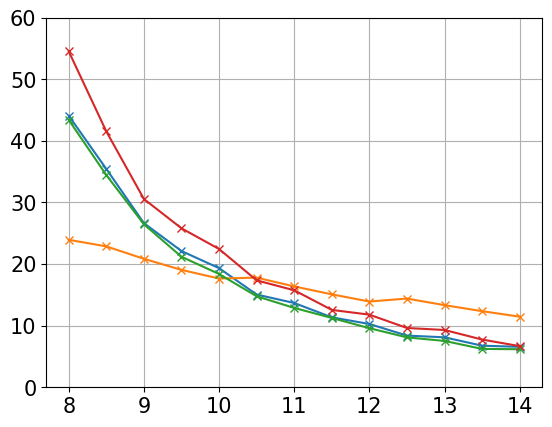

In [39]:
plt.plot(Us,100*dPdUs_NB22,'-x')
plt.plot(Us,100*dPdUs_SB04,'-x')
plt.plot(Us,100*dPdUs_NB22_nolq,'-x')
plt.plot(Us,100*dPdUs_NB22_lowtscales,'-x')
plt.ylim(0,60)
plt.grid()

In [103]:
from perlmutterNotebooks.precip_LRF_clean import *

In [111]:
Us_sub = Us#np.arange(8,14.1,2.)
dPdUs_new = np.zeros(len(Us_sub))
eps=0.1

for i,U in enumerate(Us_sub):
    sol_eps1_296   = sum_sol(U0 = U-eps, start=500,stride=2,coupling='full',eps=1/86400,Sim=W10S300,MM=Mkuang2/2,hydrostatic=True,anelastic=True)
    sol_eps1_296_2 = sum_sol(U0 = U+eps, start=500,stride=2,coupling='full',eps=1/86400,Sim=W10S300,MM=Mkuang2/2,hydrostatic=True,anelastic=True)
    
    testP  = -sol_eps1_296  [-2].integrate('pressure')*cp/Lv/g*100*86400
    testP2 = -sol_eps1_296_2[-2].integrate('pressure')*cp/Lv/g*100*86400
    
    dPdUs_new[i] = (testP2.max()/testP.max()-1)/eps/2

0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200

0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 0 50 100 150 200 250 300 350 400 450 500 

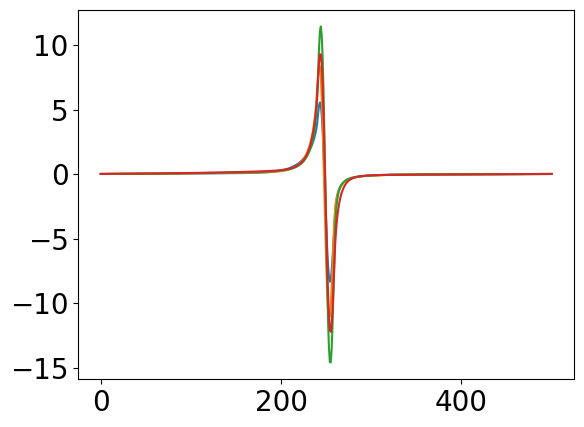

In [110]:
for U in (9,10,11,12):
    sol_eps1_296   = sum_sol(U0 = U, start=500,stride=2,coupling='full',eps=1/86400,Sim=W10S300,MM=Mkuang2/2,hydrostatic=True,anelastic=True)
    testP  = -sol_eps1_296  [-2].integrate('pressure')*cp/Lv/g*100*86400
    plt.plot(testP)


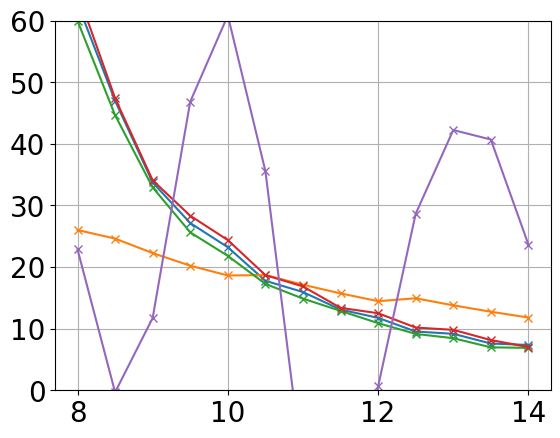

In [119]:
plt.plot(Us,100*dPdUs_NB22,'-x')
plt.plot(Us,100*dPdUs_SB04,'-x')
plt.plot(Us,100*dPdUs_NB22_nolq,'-x')
plt.plot(Us,100*dPdUs_NB22_lowtscales,'-x')
plt.plot(Us_sub,100*dPdUs_new,'-x')
plt.ylim(0,60)
plt.grid()

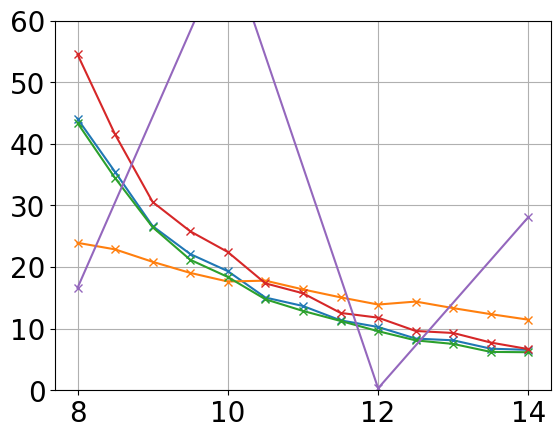

In [108]:
plt.plot(Us,100*dPdUs_NB22,'-x')
plt.plot(Us,100*dPdUs_SB04,'-x')
plt.plot(Us,100*dPdUs_NB22_nolq,'-x')
plt.plot(Us,100*dPdUs_NB22_lowtscales,'-x')
plt.plot(Us_sub,100*dPdUs_new,'-x')
plt.ylim(0,60)
plt.grid()

In [122]:
def analytic_max(U,N):
    z=np.arange(0,10000,100)
    zbot=1000
    ztop=3000
    z_slice = z[np.where((z>=zbot) & (z<=ztop))]
    alpha_c = np.cos(N*z_slice/U).mean()
    alpha_s = np.sin(N*z_slice/U).mean()

    return np.sqrt(alpha_c**2+alpha_s**2)+alpha_c


test = [(analytic_max(U+0.1,0.01)/analytic_max(U-0.1,0.01) - 1)/0.2 * 100 for U in Us]

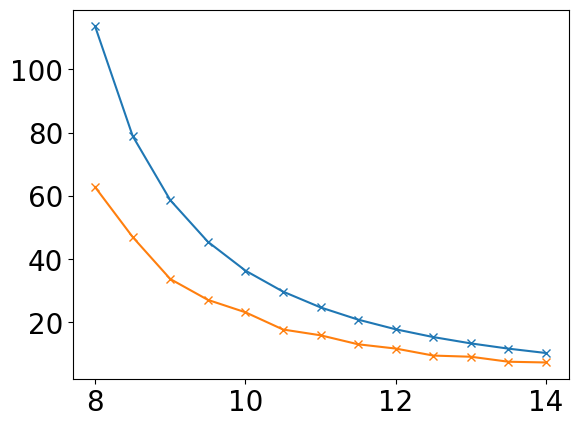

In [127]:
plt.plot(Us,test,'-x')
plt.plot(Us,100*dPdUs_NB22,'-x')

# ENSO corrs

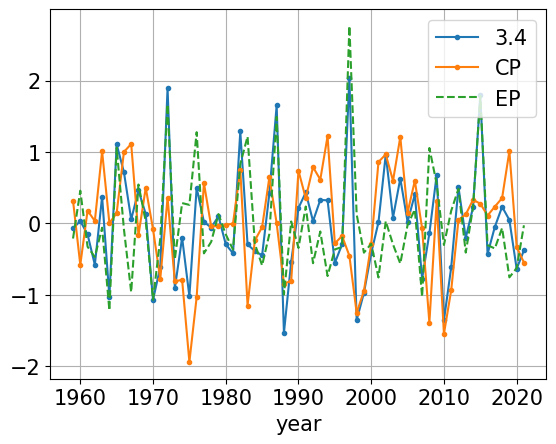

In [17]:
dirn = '/global/cfs/cdirs/m3310/wboos/projects/NAMtopo/'
filen = 'uv100_MSLP_SST_ERA5JAS1959to2021_20220815.nc'
dat = xr.open_dataset(dirn+filen)
sst = dat['sst']
sstSeas = sst.groupby('time.year').mean(dim='time')
sstSeas = sstSeas.rename({'longitude':'lon','latitude':'lat'})
nino34 = sstSeas.sel(lon=slice(360-170,360-120),lat=slice(5,-5)).mean(dim={'lon','lat'})
nino34index = nino34 - nino34.mean(dim='year')
nino4 = sstSeas.sel(lon=slice(160,360-150),lat=slice(5,-5)).mean(dim={'lon','lat'})
nino4index = nino4 - nino4.mean(dim='year')
nino3 = sstSeas.sel(lon=slice(360-150,360-90),lat=slice(5,-5)).mean(dim={'lon','lat'})
nino3index = nino3 - nino3.mean(dim='year')
ninoCPindex = (nino4index-nino4index.mean())/nino4index.std() - 0.5*(nino3index-nino3index.mean())/nino3index.std()
ninoEPindex = (nino3index-nino3index.mean())/nino3index.std() - 0.5*(nino4index-nino4index.mean())/nino4index.std()
p = nino34index.polyfit(dim='year',deg=1)
nino34indexDetrend = nino34index - xr.polyval(nino34index.year, p.polyfit_coefficients)
p = ninoCPindex.polyfit(dim='year',deg=1)
ninoCPindexDetrend = ninoCPindex - xr.polyval(ninoCPindex.year, p.polyfit_coefficients)
p = ninoEPindex.polyfit(dim='year',deg=1)
ninoEPindexDetrend = ninoEPindex - xr.polyval(ninoEPindex.year, p.polyfit_coefficients)
nino34indexDetrend.plot(marker='.',label='3.4')
ninoCPindexDetrend.plot(marker='.',label='CP')
ninoEPindexDetrend.plot(marker='',label='EP',linestyle='--')
plt.legend()
plt.grid()

In [23]:
GPCP.precip_jf_yearly = sel_months(GPCP.precip, months=[1,2]).groupby('time.year').mean().load()
p = GPCP.precip_jf_yearly.polyfit(dim='year',deg=1)
GPCP.precip_jf_yearly_detrend = GPCP.precip_jf_yearly - xr.polyval(GPCP.precip_jf_yearly.year, p.polyfit_coefficients)

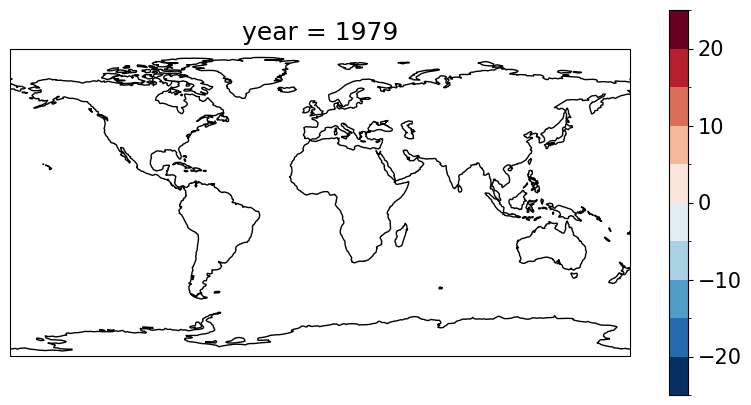

In [26]:
fig,ax=plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs=(ax,)
for ax,dataset in zip(axs,(GPCP,)):
    nino = nino34indexDetrend.sel(year=slice(1979,2017))
    precip = dataset.precip_jf_yearly
    precip_reg = linregress_xr(nino,precip,dim='year')
    fdrfact = fdr_xr_2d(precip_reg.pvalue,0.1)
    (100*precip_reg.slope /fdrfact/precip.mean('year')).plot.contourf(ax=ax,levels=np.linspace(-25,25,11),transform = ccrs.PlateCarree())
    ax.coastlines(linewidth=1)

In [27]:
precip_reg

<xarray.Dataset>
Dimensions:    (latitude: 72, longitude: 144)
Coordinates:
  * latitude   (latitude) float64 88.75 86.25 83.75 ... -83.75 -86.25 -88.75
  * longitude  (longitude) float64 1.25 3.75 6.25 8.75 ... 353.8 356.2 358.8
    year       int64 1979
Data variables:
    slope      (latitude, longitude) float64 -0.004943 -0.02681 ... -0.014
    rsquared   (latitude, longitude) float64 0.0002647 0.00738 ... 0.04624
    pvalue     (latitude, longitude) float64 0.9217 0.6031 ... 0.1372 0.1886

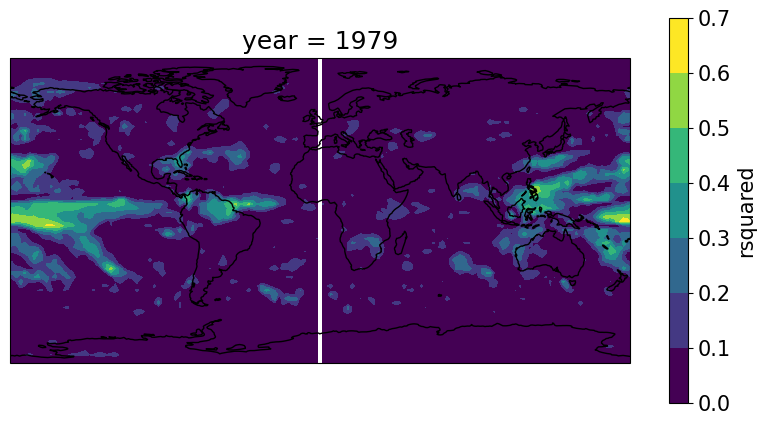

In [35]:
fig,ax=plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs=(ax,)
for ax,dataset in zip(axs,(GPCP,)):
    n=-1
    nino = nino34indexDetrend.sel(year=slice(1979+n,2017+n))
    nino = nino.data * dataset.precip_jf_yearly.year**0
    precip = dataset.precip_jf_yearly
    precip_reg = linregress_xr(nino,precip,dim='year')
    precip_reg.rsquared.plot.contourf(ax=ax,levels=np.linspace(0,0.7,8),transform = ccrs.PlateCarree())
    ax.coastlines(linewidth=1)

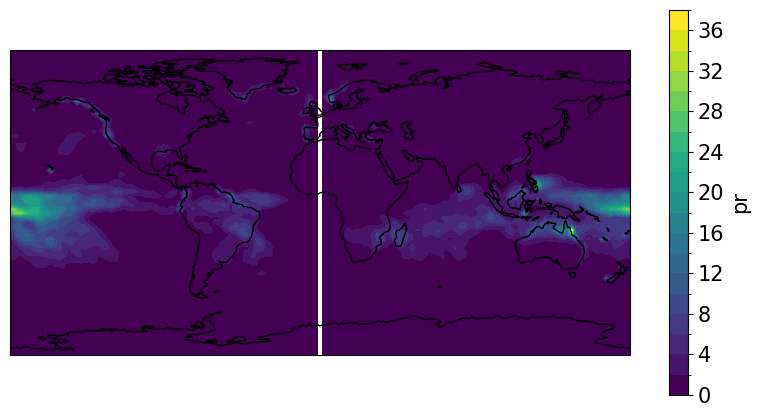

In [32]:
fig,ax=plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs=(ax,)
for ax,dataset in zip(axs,(GPCP,)):
    precip = dataset.precip_jf_yearly
    precip.var('year').plot.contourf(ax=ax,levels=21,transform = ccrs.PlateCarree())
    ax.coastlines(linewidth=1)

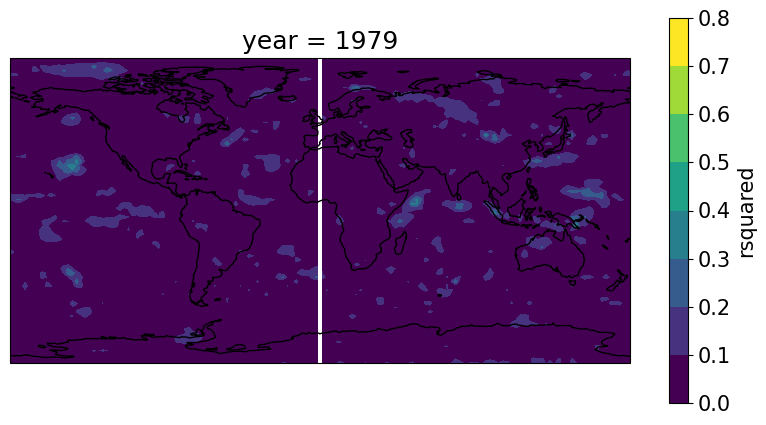

In [31]:
fig,ax=plt.subplots(1,1,figsize=(10,5),subplot_kw={'projection':ccrs.PlateCarree()})
axs=(ax,)
for ax,dataset in zip(axs,(GPCP,)):
    nino = nino34indexDetrend.sel(year=slice(1979,2017))
    precip = dataset.precip_jf_yearly_detrend
    precip_reg = linregress_xr(nino,precip,dim='year')
    precip_reg.rsquared.plot.contourf(ax=ax,levels=np.linspace(0,0.8,9),transform = ccrs.PlateCarree())
    ax.coastlines(linewidth=1)